# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

import os
import sys
import numpy as np
import pandas as pd
import jax
import jax.numpy as jnp
import diffrax as dfx
from functools import partial
import dynesty
from dynesty import plotting as dyplot
import matplotlib.pyplot as plt

jax.config.update('jax_platform_name', 'cpu')


if __package__ is None:

    module_path = os.path.abspath(os.path.join('..'))
    sys.path.append(module_path)

    __package__ = os.path.basename(module_path)


root_dir = '..'

In [3]:
from synbio_morpher.utils.modelling.deterministic import bioreaction_sim_dfx_expanded
from synbio_morpher.utils.misc.helper import vanilla_return
from synbio_morpher.utils.results.analytics.timeseries import generate_analytics
from synbio_morpher.utils.results.analytics.naming import get_true_interaction_cols
from bioreaction.simulation.manager import simulate_steady_states



# Simulation

In [4]:

def scale_rates(forward_rates, reverse_rates, cushioning: int = 4):
    rate_max = np.max([np.max(np.asarray(forward_rates)),
                        np.max(np.asarray(reverse_rates))])

    dt0 = 1 / (cushioning * rate_max)
    return dt0

In [5]:
def optimise_sp(s, p):
    s_lin = 1 / p
    return s - s_lin

In [6]:
def one_step_de_sim_expanded(spec_conc, inputs, outputs, forward_rates, reverse_rates):
    concentration_factors_in = jnp.prod(
        jnp.power(spec_conc, (inputs)), axis=1)
    concentration_factors_out = jnp.prod(
        jnp.power(spec_conc, (outputs)), axis=1)
    forward_delta = concentration_factors_in * forward_rates
    reverse_delta = concentration_factors_out * reverse_rates
    return (forward_delta - reverse_delta) @ (outputs - inputs)


def dummy_simfunc(
        y0, t0, t1, dt0,
        forward_rates,
        reverse_rates,
        inputs,
        outputs,
        threshold = 0.01
        # max_steps,
        # signal=vanilla_return, signal_onehot=1
    ):
    steps = int((t1 - t0) / dt0)
    y = np.zeros((steps, len(y0.squeeze())))
    time = np.arange(t0, t1, dt0)
    y[0] = y0
    for t in range(1, steps):
        yt = one_step_de_sim_expanded(
            spec_conc=y[t-1], inputs=inputs,
            outputs=outputs,
            forward_rates=forward_rates,
            reverse_rates=reverse_rates)
        y[t] = y[t-1] + yt * dt0
        if np.sum((np.abs(yt) - threshold ) * dt0) < 0:
            return y[:t], time[:t]
    return y, time

In [7]:
def compute_analytics(y, t, labels, signal_onehot):
    y = np.swapaxes(y, 0, 1)
    
    analytics_func = partial(
        generate_analytics, time=t, labels=labels,
        signal_onehot=signal_onehot, signal_time=0,
        ref_circuit_data=None)
    return analytics_func(data=y, time=t, labels=labels)

In [8]:
def R(B11, B12, B13, B22, B23, B33):
    unbound_species = ['RNA_0', 'RNA_1', 'RNA_2']
    species = ['RNA_0', 'RNA_1', 'RNA_2', 'RNA_0-0', 'RNA_0-1', 'RNA_0-2', 'RNA_1-1', 'RNA_1-2', 'RNA_2-2']
    signal_species = ['RNA_0']
    output_species = ['RNA_1']
    s_idxs = [species.index(s) for s in signal_species]
    output_idxs = [species.index(s) for s in output_species]
    signal_onehot = np.array([1 if s in [species.index(ss) for ss in signal_species] else 0 for s in np.arange(len(species))])
    
    signal_target = 2
    k = 0.00150958097
    N0 = 200
    
    # Amounts
    y00 = np.array([[N0, N0, N0, 0, 0, 0, 0, 0, 0]])
    
    # Reactions
    inputs = np.array([
        [2, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 2, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 2, 0, 0, 0, 0, 0, 0],
    ])
    outputs = np.array([
        [0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1],
    ])
    
    # Rates
    reverse_rates = np.array([[B11, B12, B13, B22, B23, B33]])
    forward_rates = np.ones_like(reverse_rates) * k
    
    # Sim params
    t0 = 0
    t1 = 100
    dt0 = scale_rates(forward_rates, reverse_rates, cushioning=4)
    max_steps = 16**4 * 10
    # print('\n\nInput N:', y00)
    # print('Input B:', reverse_rates)
    sim_func = jax.jit(partial(bioreaction_sim_dfx_expanded,
        t0=t0, t1=t1, dt0=dt0,
        signal=vanilla_return, signal_onehot=1,
        forward_rates=forward_rates,
        inputs=inputs,
        outputs=outputs,
        solver=dfx.Tsit5(),
        saveat=dfx.SaveAt(
            ts=np.linspace(t0, t1, 500)),  # int(np.min([500, self.t1-self.t0]))))
        max_steps=max_steps
        ))
    
    y0, t = simulate_steady_states(y0=y00, total_time=t1-t0, sim_func=sim_func, t0=t0, t1=t1, threshold=0.1, reverse_rates=reverse_rates, disable_logging=True)
    y0 = np.array(y0.squeeze()[-1, :]).reshape(y00.shape)
    
    # Signal
    
    y0s = y0 * ((signal_onehot == 0) * 1) + y00 * signal_target * signal_onehot
    y, t = simulate_steady_states(y0s, total_time=t1-t0, sim_func=sim_func, t0=t0, t1=t1, threshold=0.1, reverse_rates=reverse_rates, disable_logging=True)
    y = np.concatenate([y0, y.squeeze()[:-1, :]], axis=0)
    y1 = np.array(y[-1, :])
        
    # print('Output:', y1)
    
    analytics = compute_analytics(y, t, labels=np.arange(y.shape[-1]), signal_onehot=signal_onehot)
    
    s = analytics['sensitivity_wrt_species-0']
    p = analytics['precision_wrt_species-0']
    # print(f'Sensitivity {output_idxs[0]}:', s[tuple(output_idxs)])
    # print(f'Precision {output_idxs[0]}:', p[tuple(output_idxs)])
    
    r = optimise_sp(
        s=s.squeeze()[tuple(output_idxs)], p=p.squeeze()[tuple(output_idxs)]
    )
    
    return r

### Check that R is working

In [ ]:

dummy_B = np.array([0.000164, 899.999500, 0.000114, 899.999500, 899.9995, 899.9995], dtype=np.float64)

# Min sensitivity:
# toy_mRNA_circuit_11232	RNA_2_m15-0
# For [0.000164, 899.999500, 0.000114, 899.999500, 899.9995, 899.9995] :
# s = 2.442697e-07

r = R(*dummy_B)

# Log likelihood

Let's first create a realistic sampler of binding rates of dissociation. See explanation notebook 5, 'examine binding energies'.

In [ ]:
fn = '../data/generate_seqs_flexible/2023_04_17_205800/circuit_stats.csv'
data = pd.read_csv(fn)
datam = data.melt(['name'], value_vars=get_true_interaction_cols(data, 'binding_rates_dissociation'), var_name='idx', value_name='binding_rates_dissociation')

In [ ]:
import scipy.stats as st
def get_best_distribution(data):
    dist_names = ["norm", "exponweib", "weibull_max", "weibull_min", "pareto", "genextreme"]
    dist_results = []
    params = {}
    for dist_name in dist_names:
        dist = getattr(st, dist_name)
        param = dist.fit(data)

        params[dist_name] = param
        # Applying the Kolmogorov-Smirnov test
        D, p = st.kstest(data, dist_name, args=param)
        print("p value for "+dist_name+" = "+str(p))
        dist_results.append((dist_name, p))

    # select the best fitted distribution
    best_dist, best_p = (max(dist_results, key=lambda item: item[1]))
    # store the name of the best fit and its p value

    print("Best fitting distribution: "+str(best_dist))
    print("Best p value: "+ str(best_p))
    print("Parameters for the best fit: "+ str(params[best_dist]))

    return best_dist, best_p, params[best_dist]

In [ ]:
get_best_distribution(datam['binding_rates_dissociation'].to_numpy())

## Actual log likelihood

In [ ]:
ndim = 6

def loglike(B):
    
    L = - 1 / (R(*B) + 0.0001)
    
    print(L)
    
    return L


def ptform(u):
    R_max = 1
    R_min = 0.00001
    x = R_max * u + R_min
    
    return x

# Sampling

In [ ]:

sampler = dynesty.NestedSampler(loglike, ptform, ndim)
sampler.run_nested(maxiter=500)
sresults = sampler.results

# fig, axes = plt.subplots(6, 13, figsize=(25, 10))
# axes = axes.reshape((6, 13))  # reshape axes

# # add white space
# [a.set_frame_on(False) for a in axes[:, 6]]
# [a.set_xticks([]) for a in axes[:, 6]]
# [a.set_yticks([]) for a in axes[:, 6]]

# # plot initial run (res1; left)
# fg, ax = dyplot.cornerpoints(sresults, cmap='plasma', truths=np.zeros(ndim),
#                              kde=False, fig=(fig, axes[:, :2]))

-51.827194
-10000.0
-36.194363
-105.56377
-543.87103
-76.082184
-34.926517
-65.988716
-2467.2705
-782.5821
-61.331875
-86.72978
-139.0176
-52.50425
-49.483337
-68.83457
-38.865726
-85.044174
-68.144684
-10000.0
-341.91437
-2164.1467
-10000.0
-10000.0
-10000.0
-71.04485
-54.77932
-67.299904
-6370.1553
-45.891445
-76.96891
-123.71766
-9999.628
-10000.0
-293.07123
-59.426613
-125.71635
-479.53778
-62.27851
-8066.079
-62.554752
-47.04682
-68.14223
-99.4964
-10000.0
-71.9502
-10000.0
-146.06021
-62.436775
-97.43374
-303.1379
-130.34084
-64.70127
-42.176273
-9997.0205
-42.365204
-10000.0
-42.361217
-10000.0
-87.82733
-10000.373
-55.270348
-10000.0
-117.50238
-10000.0
-9999.628
-181.9886
-55.27504
-58.307938
-140.91814
-67.65675
-121.15197
-10000.0
-236.1343
-65.05139
-118.06073
-55.91817
-71.57813
-55.107132
-21.542622
-10000.0
-8775.398
-298.97665
-69.78615
-10000.0
-160.60516
-85.613846
-138.33966
-10000.0
-84.03829
-28.718096
-388.2028
-158.31488
-84.6765
-50.259155
-10000.0
-10000.0
-100

1it [00:00,  1.40it/s, bound: 0 | nc: 1 | ncall: 501 | eff(%):  0.200 | loglstar:   -inf < -10000.373 <    inf | logz: -10007.283 +/-  0.117 | dlogz:    inf >  0.509]

-70.01021


2it [00:01,  1.41it/s, bound: 0 | nc: 1 | ncall: 502 | eff(%):  0.398 | loglstar:   -inf < -10000.373 <    inf | logz: -10006.184 +/-  0.108 | dlogz: 9991.219 >  0.509]

-869.667


3it [00:02,  1.41it/s, bound: 0 | nc: 1 | ncall: 503 | eff(%):  0.596 | loglstar:   -inf < -10000.373 <    inf | logz: -10005.673 +/-  0.103 | dlogz: 9990.118 >  0.509]

-34.27738


4it [00:02,  1.40it/s, bound: 0 | nc: 1 | ncall: 504 | eff(%):  0.794 | loglstar:   -inf < -10000.373 <    inf | logz: -10005.337 +/-  0.100 | dlogz: 9989.605 >  0.509]

-43.52901


5it [00:03,  1.41it/s, bound: 0 | nc: 1 | ncall: 505 | eff(%):  0.990 | loglstar:   -inf < -10000.373 <    inf | logz: -10005.086 +/-  0.097 | dlogz: 9989.267 >  0.509]

-94.67594


6it [00:04,  1.39it/s, bound: 0 | nc: 1 | ncall: 506 | eff(%):  1.186 | loglstar:   -inf < -10000.373 <    inf | logz: -10004.885 +/-  0.095 | dlogz: 9989.013 >  0.509]

-75.58669


7it [00:05,  1.39it/s, bound: 0 | nc: 1 | ncall: 507 | eff(%):  1.381 | loglstar:   -inf < -10000.373 <    inf | logz: -10004.718 +/-  0.093 | dlogz: 9988.811 >  0.509]

-111.30436


8it [00:05,  1.37it/s, bound: 0 | nc: 1 | ncall: 508 | eff(%):  1.575 | loglstar:   -inf < -10000.000 <    inf | logz: -10004.547 +/-  0.092 | dlogz: 9988.642 >  0.509]

-50.31537


9it [00:06,  1.35it/s, bound: 0 | nc: 1 | ncall: 509 | eff(%):  1.768 | loglstar:   -inf < -10000.000 <    inf | logz: -10004.377 +/-  0.090 | dlogz: 9988.469 >  0.509]

-104.71973


10it [00:07,  1.36it/s, bound: 0 | nc: 1 | ncall: 510 | eff(%):  1.961 | loglstar:   -inf < -10000.000 <    inf | logz: -10004.231 +/-  0.089 | dlogz: 9988.297 >  0.509]

-25.998652
-10000.0
-10000.0


11it [00:09,  1.15s/it, bound: 0 | nc: 3 | ncall: 513 | eff(%):  2.144 | loglstar:   -inf < -10000.000 <    inf | logz: -10004.104 +/-  0.088 | dlogz: 9988.149 >  0.509]

-65.33675


12it [00:10,  1.02s/it, bound: 0 | nc: 1 | ncall: 514 | eff(%):  2.335 | loglstar:   -inf < -10000.000 <    inf | logz: -10003.992 +/-  0.087 | dlogz: 9988.020 >  0.509]

-5462.606


13it [00:10,  1.09it/s, bound: 0 | nc: 1 | ncall: 515 | eff(%):  2.524 | loglstar:   -inf < -10000.000 <    inf | logz: -10003.890 +/-  0.086 | dlogz: 9987.905 >  0.509]

-55.639763


14it [00:11,  1.17it/s, bound: 0 | nc: 1 | ncall: 516 | eff(%):  2.713 | loglstar:   -inf < -10000.000 <    inf | logz: -10003.798 +/-  0.085 | dlogz: 9987.802 >  0.509]

-43.808853


15it [00:12,  1.24it/s, bound: 0 | nc: 1 | ncall: 517 | eff(%):  2.901 | loglstar:   -inf < -10000.000 <    inf | logz: -10003.714 +/-  0.084 | dlogz: 9987.708 >  0.509]

-31.129444


16it [00:12,  1.29it/s, bound: 0 | nc: 1 | ncall: 518 | eff(%):  3.089 | loglstar:   -inf < -10000.000 <    inf | logz: -10003.637 +/-  0.083 | dlogz: 9987.622 >  0.509]

-137.49088
-10000.0


17it [00:14,  1.03it/s, bound: 0 | nc: 2 | ncall: 520 | eff(%):  3.269 | loglstar:   -inf < -10000.000 <    inf | logz: -10003.565 +/-  0.083 | dlogz: 9987.542 >  0.509]

-238.82614


18it [00:15,  1.12it/s, bound: 0 | nc: 1 | ncall: 521 | eff(%):  3.455 | loglstar:   -inf < -10000.000 <    inf | logz: -10003.497 +/-  0.082 | dlogz: 9987.468 >  0.509]

-102.96701


19it [00:15,  1.19it/s, bound: 0 | nc: 1 | ncall: 522 | eff(%):  3.640 | loglstar:   -inf < -10000.000 <    inf | logz: -10003.434 +/-  0.081 | dlogz: 9987.399 >  0.509]

-80.48034
-10000.0


20it [00:17,  1.02s/it, bound: 0 | nc: 2 | ncall: 524 | eff(%):  3.817 | loglstar:   -inf < -10000.000 <    inf | logz: -10003.375 +/-  0.081 | dlogz: 9987.334 >  0.509]

-94.49608


21it [00:17,  1.08it/s, bound: 0 | nc: 1 | ncall: 525 | eff(%):  4.000 | loglstar:   -inf < -10000.000 <    inf | logz: -10003.319 +/-  0.080 | dlogz: 9987.273 >  0.509]

-51.69076


22it [00:18,  1.16it/s, bound: 0 | nc: 1 | ncall: 526 | eff(%):  4.183 | loglstar:   -inf < -10000.000 <    inf | logz: -10003.266 +/-  0.079 | dlogz: 9987.215 >  0.509]

-742.92786


23it [00:19,  1.23it/s, bound: 0 | nc: 1 | ncall: 527 | eff(%):  4.364 | loglstar:   -inf < -10000.000 <    inf | logz: -10003.216 +/-  0.079 | dlogz: 9987.160 >  0.509]

-84.35064


24it [00:20,  1.27it/s, bound: 0 | nc: 1 | ncall: 528 | eff(%):  4.545 | loglstar:   -inf < -10000.000 <    inf | logz: -10003.168 +/-  0.078 | dlogz: 9987.107 >  0.509]

-79.12373


25it [00:20,  1.31it/s, bound: 0 | nc: 1 | ncall: 529 | eff(%):  4.726 | loglstar:   -inf < -10000.000 <    inf | logz: -10003.122 +/-  0.078 | dlogz: 9987.057 >  0.509]

-87.33065


26it [00:21,  1.34it/s, bound: 0 | nc: 1 | ncall: 530 | eff(%):  4.906 | loglstar:   -inf < -10000.000 <    inf | logz: -10003.079 +/-  0.077 | dlogz: 9987.009 >  0.509]

-74.4404


27it [00:22,  1.36it/s, bound: 0 | nc: 1 | ncall: 531 | eff(%):  5.085 | loglstar:   -inf < -10000.000 <    inf | logz: -10003.037 +/-  0.076 | dlogz: 9986.964 >  0.509]

-48.32252
-10000.0


28it [00:23,  1.06it/s, bound: 0 | nc: 2 | ncall: 533 | eff(%):  5.253 | loglstar:   -inf < -10000.000 <    inf | logz: -10002.997 +/-  0.076 | dlogz: 9986.920 >  0.509]

-43.518078


29it [00:24,  1.15it/s, bound: 0 | nc: 1 | ncall: 534 | eff(%):  5.431 | loglstar:   -inf < -10000.000 <    inf | logz: -10002.958 +/-  0.075 | dlogz: 9986.877 >  0.509]

-85.85387


30it [00:24,  1.21it/s, bound: 0 | nc: 1 | ncall: 535 | eff(%):  5.607 | loglstar:   -inf < -10000.000 <    inf | logz: -10002.921 +/-  0.075 | dlogz: 9986.837 >  0.509]

-65.8948


31it [00:25,  1.27it/s, bound: 0 | nc: 1 | ncall: 536 | eff(%):  5.784 | loglstar:   -inf < -10000.000 <    inf | logz: -10002.885 +/-  0.075 | dlogz: 9986.797 >  0.509]

-9958.819


32it [00:26,  1.31it/s, bound: 0 | nc: 1 | ncall: 537 | eff(%):  5.959 | loglstar:   -inf < -10000.000 <    inf | logz: -10002.850 +/-  0.074 | dlogz: 9986.760 >  0.509]

-86.62113


33it [00:27,  1.34it/s, bound: 0 | nc: 1 | ncall: 538 | eff(%):  6.134 | loglstar:   -inf < -10000.000 <    inf | logz: -10002.817 +/-  0.074 | dlogz: 9986.723 >  0.509]

-27.240316
-10000.0


34it [00:28,  1.02it/s, bound: 0 | nc: 2 | ncall: 540 | eff(%):  6.296 | loglstar:   -inf < -10000.000 <    inf | logz: -10002.784 +/-  0.073 | dlogz: 9986.687 >  0.509]

-428.02805
-10000.0


35it [00:30,  1.15s/it, bound: 0 | nc: 2 | ncall: 542 | eff(%):  6.458 | loglstar:   -inf < -10000.000 <    inf | logz: -10002.753 +/-  0.073 | dlogz: 9986.653 >  0.509]

-95.19062
-10000.0


36it [00:31,  1.28s/it, bound: 0 | nc: 2 | ncall: 544 | eff(%):  6.618 | loglstar:   -inf < -10000.000 <    inf | logz: -10002.723 +/-  0.072 | dlogz: 9986.619 >  0.509]

-50.293766


37it [00:32,  1.13s/it, bound: 0 | nc: 1 | ncall: 545 | eff(%):  6.789 | loglstar:   -inf < -10000.000 <    inf | logz: -10002.693 +/-  0.072 | dlogz: 9986.587 >  0.509]

-128.43268


38it [00:33,  1.01s/it, bound: 0 | nc: 1 | ncall: 546 | eff(%):  6.960 | loglstar:   -inf < -10000.000 <    inf | logz: -10002.664 +/-  0.072 | dlogz: 9986.555 >  0.509]

-92.2632


39it [00:34,  1.05it/s, bound: 0 | nc: 1 | ncall: 547 | eff(%):  7.130 | loglstar:   -inf < -10000.000 <    inf | logz: -10002.637 +/-  0.071 | dlogz: 9986.524 >  0.509]

-30.188366


40it [00:34,  1.11it/s, bound: 0 | nc: 1 | ncall: 548 | eff(%):  7.299 | loglstar:   -inf < -10000.000 <    inf | logz: -10002.609 +/-  0.071 | dlogz: 9986.494 >  0.509]

-55.12589


41it [00:35,  1.15it/s, bound: 0 | nc: 1 | ncall: 549 | eff(%):  7.468 | loglstar:   -inf < -10000.000 <    inf | logz: -10002.583 +/-  0.070 | dlogz: 9986.465 >  0.509]

-145.73802


42it [00:36,  1.18it/s, bound: 0 | nc: 1 | ncall: 550 | eff(%):  7.636 | loglstar:   -inf < -10000.000 <    inf | logz: -10002.557 +/-  0.070 | dlogz: 9986.437 >  0.509]

-148.04813


43it [00:37,  1.22it/s, bound: 0 | nc: 1 | ncall: 551 | eff(%):  7.804 | loglstar:   -inf < -10000.000 <    inf | logz: -10002.532 +/-  0.070 | dlogz: 9986.409 >  0.509]

-91.08946
-10000.0


44it [00:38,  1.03s/it, bound: 0 | nc: 2 | ncall: 553 | eff(%):  7.957 | loglstar:   -inf < -10000.000 <    inf | logz: -10002.508 +/-  0.069 | dlogz: 9986.381 >  0.509]

-129.27777


45it [00:39,  1.05it/s, bound: 0 | nc: 1 | ncall: 554 | eff(%):  8.123 | loglstar:   -inf < -10000.000 <    inf | logz: -10002.484 +/-  0.069 | dlogz: 9986.355 >  0.509]

-2645.9214


46it [00:40,  1.11it/s, bound: 0 | nc: 1 | ncall: 555 | eff(%):  8.288 | loglstar:   -inf < -10000.000 <    inf | logz: -10002.461 +/-  0.069 | dlogz: 9986.329 >  0.509]

-9997.394


47it [00:41,  1.11it/s, bound: 0 | nc: 1 | ncall: 556 | eff(%):  8.453 | loglstar:   -inf < -10000.000 <    inf | logz: -10002.438 +/-  0.068 | dlogz: 9986.303 >  0.509]

-51.454243


48it [00:42,  1.13it/s, bound: 0 | nc: 1 | ncall: 557 | eff(%):  8.618 | loglstar:   -inf < -10000.000 <    inf | logz: -10002.416 +/-  0.068 | dlogz: 9986.278 >  0.509]

-102.210335


49it [00:42,  1.14it/s, bound: 0 | nc: 1 | ncall: 558 | eff(%):  8.781 | loglstar:   -inf < -10000.000 <    inf | logz: -10002.394 +/-  0.068 | dlogz: 9986.254 >  0.509]

-43.204666


50it [00:43,  1.14it/s, bound: 0 | nc: 1 | ncall: 559 | eff(%):  8.945 | loglstar:   -inf < -10000.000 <    inf | logz: -10002.372 +/-  0.067 | dlogz: 9986.230 >  0.509]

-6664.477


51it [00:44,  1.15it/s, bound: 0 | nc: 1 | ncall: 560 | eff(%):  9.107 | loglstar:   -inf < -10000.000 <    inf | logz: -10002.352 +/-  0.067 | dlogz: 9986.206 >  0.509]

-100.3929


52it [00:45,  1.15it/s, bound: 0 | nc: 1 | ncall: 561 | eff(%):  9.269 | loglstar:   -inf < -10000.000 <    inf | logz: -10002.331 +/-  0.067 | dlogz: 9986.183 >  0.509]

-85.31474


53it [00:46,  1.15it/s, bound: 0 | nc: 1 | ncall: 562 | eff(%):  9.431 | loglstar:   -inf < -10000.000 <    inf | logz: -10002.311 +/-  0.066 | dlogz: 9986.161 >  0.509]

-179.99777


54it [00:47,  1.15it/s, bound: 0 | nc: 1 | ncall: 563 | eff(%):  9.591 | loglstar:   -inf < -10000.000 <    inf | logz: -10002.291 +/-  0.066 | dlogz: 9986.138 >  0.509]

-67.41346
-10000.0


55it [00:48,  1.13s/it, bound: 0 | nc: 2 | ncall: 565 | eff(%):  9.735 | loglstar:   -inf < -10000.000 <    inf | logz: -10002.272 +/-  0.066 | dlogz: 9986.117 >  0.509]

-3696.5393


56it [00:49,  1.05s/it, bound: 0 | nc: 1 | ncall: 566 | eff(%):  9.894 | loglstar:   -inf < -10000.000 <    inf | logz: -10002.253 +/-  0.065 | dlogz: 9986.095 >  0.509]

-193.9813


57it [00:50,  1.00it/s, bound: 0 | nc: 1 | ncall: 567 | eff(%): 10.053 | loglstar:   -inf < -10000.000 <    inf | logz: -10002.235 +/-  0.065 | dlogz: 9986.074 >  0.509]

-213.97983


58it [00:51,  1.04it/s, bound: 0 | nc: 1 | ncall: 568 | eff(%): 10.211 | loglstar:   -inf < -10000.000 <    inf | logz: -10002.216 +/-  0.065 | dlogz: 9986.053 >  0.509]

-134.45946


59it [00:52,  1.07it/s, bound: 0 | nc: 1 | ncall: 569 | eff(%): 10.369 | loglstar:   -inf < -10000.000 <    inf | logz: -10002.198 +/-  0.064 | dlogz: 9986.033 >  0.509]

-27.586071


60it [00:53,  1.09it/s, bound: 0 | nc: 1 | ncall: 570 | eff(%): 10.526 | loglstar:   -inf < -10000.000 <    inf | logz: -10002.181 +/-  0.064 | dlogz: 9986.013 >  0.509]

-81.57845
-10000.0


61it [00:55,  1.17s/it, bound: 0 | nc: 2 | ncall: 572 | eff(%): 10.664 | loglstar:   -inf < -10000.000 <    inf | logz: -10002.164 +/-  0.064 | dlogz: 9985.993 >  0.509]

-88.926636


62it [00:55,  1.08s/it, bound: 0 | nc: 1 | ncall: 573 | eff(%): 10.820 | loglstar:   -inf < -10000.000 <    inf | logz: -10002.147 +/-  0.064 | dlogz: 9985.973 >  0.509]

-56.981976


63it [00:56,  1.02s/it, bound: 0 | nc: 1 | ncall: 574 | eff(%): 10.976 | loglstar:   -inf < -10000.000 <    inf | logz: -10002.130 +/-  0.063 | dlogz: 9985.954 >  0.509]

-73.36394


64it [00:57,  1.02it/s, bound: 0 | nc: 1 | ncall: 575 | eff(%): 11.130 | loglstar:   -inf < -10000.000 <    inf | logz: -10002.114 +/-  0.063 | dlogz: 9985.935 >  0.509]

-9059.417


65it [00:58,  1.06it/s, bound: 0 | nc: 1 | ncall: 576 | eff(%): 11.285 | loglstar:   -inf < -10000.000 <    inf | logz: -10002.097 +/-  0.063 | dlogz: 9985.917 >  0.509]

-65.64757


66it [00:59,  1.08it/s, bound: 0 | nc: 1 | ncall: 577 | eff(%): 11.438 | loglstar:   -inf < -10000.000 <    inf | logz: -10002.081 +/-  0.062 | dlogz: 9985.898 >  0.509]

-107.59535


67it [01:00,  1.10it/s, bound: 0 | nc: 1 | ncall: 578 | eff(%): 11.592 | loglstar:   -inf < -10000.000 <    inf | logz: -10002.066 +/-  0.062 | dlogz: 9985.880 >  0.509]

-49.323658
-10000.0


68it [01:02,  1.16s/it, bound: 0 | nc: 2 | ncall: 580 | eff(%): 11.724 | loglstar:   -inf < -10000.000 <    inf | logz: -10002.050 +/-  0.062 | dlogz: 9985.862 >  0.509]

-69.228226


69it [01:02,  1.07s/it, bound: 0 | nc: 1 | ncall: 581 | eff(%): 11.876 | loglstar:   -inf < -10000.000 <    inf | logz: -10002.035 +/-  0.062 | dlogz: 9985.844 >  0.509]

-66.25393


70it [01:03,  1.01s/it, bound: 0 | nc: 1 | ncall: 582 | eff(%): 12.027 | loglstar:   -inf < -10000.000 <    inf | logz: -10002.020 +/-  0.061 | dlogz: 9985.827 >  0.509]

-51.90272


71it [01:04,  1.03it/s, bound: 0 | nc: 1 | ncall: 583 | eff(%): 12.178 | loglstar:   -inf < -10000.000 <    inf | logz: -10002.006 +/-  0.061 | dlogz: 9985.810 >  0.509]

-83.0032
-10000.0


72it [01:06,  1.13s/it, bound: 0 | nc: 2 | ncall: 585 | eff(%): 12.308 | loglstar:   -inf < -10000.000 <    inf | logz: -10001.991 +/-  0.061 | dlogz: 9985.793 >  0.509]

-238.06639


73it [01:06,  1.00s/it, bound: 0 | nc: 1 | ncall: 586 | eff(%): 12.457 | loglstar:   -inf < -10000.000 <    inf | logz: -10001.977 +/-  0.061 | dlogz: 9985.776 >  0.509]

-373.68466


74it [01:07,  1.09it/s, bound: 0 | nc: 1 | ncall: 587 | eff(%): 12.606 | loglstar:   -inf < -10000.000 <    inf | logz: -10001.963 +/-  0.060 | dlogz: 9985.759 >  0.509]

-59.410774


75it [01:08,  1.17it/s, bound: 0 | nc: 1 | ncall: 588 | eff(%): 12.755 | loglstar:   -inf < -10000.000 <    inf | logz: -10001.949 +/-  0.060 | dlogz: 9985.743 >  0.509]

-68.149574


76it [01:09,  1.23it/s, bound: 0 | nc: 1 | ncall: 589 | eff(%): 12.903 | loglstar:   -inf < -10000.000 <    inf | logz: -10001.935 +/-  0.060 | dlogz: 9985.727 >  0.509]

-160.51219
-10000.0
-10000.0
-10000.0


77it [01:11,  1.41s/it, bound: 0 | nc: 4 | ncall: 593 | eff(%): 12.985 | loglstar:   -inf < -10000.000 <    inf | logz: -10001.921 +/-  0.059 | dlogz: 9985.711 >  0.509]

-94.21269


78it [01:12,  1.21s/it, bound: 0 | nc: 1 | ncall: 594 | eff(%): 13.131 | loglstar:   -inf < -10000.000 <    inf | logz: -10001.908 +/-  0.059 | dlogz: 9985.695 >  0.509]

-79.85312


79it [01:13,  1.06s/it, bound: 0 | nc: 1 | ncall: 595 | eff(%): 13.277 | loglstar:   -inf < -10000.000 <    inf | logz: -10001.895 +/-  0.059 | dlogz: 9985.679 >  0.509]

-44.10953


80it [01:14,  1.04it/s, bound: 0 | nc: 1 | ncall: 596 | eff(%): 13.423 | loglstar:   -inf < -10000.000 <    inf | logz: -10001.882 +/-  0.059 | dlogz: 9985.664 >  0.509]

-86.65333
-10000.0


81it [01:15,  1.10s/it, bound: 0 | nc: 2 | ncall: 598 | eff(%): 13.545 | loglstar:   -inf < -10000.000 <    inf | logz: -10001.869 +/-  0.058 | dlogz: 9985.648 >  0.509]

-176.23248


82it [01:16,  1.02it/s, bound: 0 | nc: 1 | ncall: 599 | eff(%): 13.689 | loglstar:   -inf < -10000.000 <    inf | logz: -10001.856 +/-  0.058 | dlogz: 9985.633 >  0.509]

-1190.6147
-10000.0
-10000.0


83it [01:18,  1.32s/it, bound: 0 | nc: 3 | ncall: 602 | eff(%): 13.787 | loglstar:   -inf < -10000.000 <    inf | logz: -10001.844 +/-  0.058 | dlogz: 9985.618 >  0.509]

-47.209534


84it [01:18,  1.14s/it, bound: 0 | nc: 1 | ncall: 603 | eff(%): 13.930 | loglstar:   -inf < -10000.000 <    inf | logz: -10001.831 +/-  0.058 | dlogz: 9985.603 >  0.509]

-2871.9644


85it [01:19,  1.01s/it, bound: 0 | nc: 1 | ncall: 604 | eff(%): 14.073 | loglstar:   -inf < -10000.000 <    inf | logz: -10001.819 +/-  0.057 | dlogz: 9985.588 >  0.509]

-94.18362


86it [01:20,  1.09it/s, bound: 0 | nc: 1 | ncall: 605 | eff(%): 14.215 | loglstar:   -inf < -10000.000 <    inf | logz: -10001.807 +/-  0.057 | dlogz: 9985.574 >  0.509]

-45.054626


87it [01:21,  1.17it/s, bound: 0 | nc: 1 | ncall: 606 | eff(%): 14.356 | loglstar:   -inf < -10000.000 <    inf | logz: -10001.795 +/-  0.057 | dlogz: 9985.559 >  0.509]

-84.16135


88it [01:21,  1.23it/s, bound: 0 | nc: 1 | ncall: 607 | eff(%): 14.498 | loglstar:   -inf < -9999.814 <    inf | logz: -10001.784 +/-  0.057 | dlogz: 9985.545 >  0.509] 

-8725.197


89it [01:22,  1.28it/s, bound: 0 | nc: 1 | ncall: 608 | eff(%): 14.638 | loglstar:   -inf < -9999.814 <    inf | logz: -10001.773 +/-  0.057 | dlogz: 9985.532 >  0.509]

-73.6478


90it [01:23,  1.32it/s, bound: 0 | nc: 1 | ncall: 609 | eff(%): 14.778 | loglstar:   -inf < -9999.628 <    inf | logz: -10001.760 +/-  0.056 | dlogz: 9985.518 >  0.509]

-41.884113


91it [01:23,  1.35it/s, bound: 0 | nc: 1 | ncall: 610 | eff(%): 14.918 | loglstar:   -inf < -9999.628 <    inf | logz: -10001.746 +/-  0.056 | dlogz: 9985.504 >  0.509]

-50.15467


92it [01:24,  1.37it/s, bound: 0 | nc: 1 | ncall: 611 | eff(%): 15.057 | loglstar:   -inf < -9999.628 <    inf | logz: -10001.732 +/-  0.056 | dlogz: 9985.488 >  0.509]

-47.756214


93it [01:25,  1.38it/s, bound: 0 | nc: 1 | ncall: 612 | eff(%): 15.196 | loglstar:   -inf < -9999.255 <    inf | logz: -10001.716 +/-  0.056 | dlogz: 9985.472 >  0.509]

-57.173954
-10000.0


94it [01:26,  1.07it/s, bound: 0 | nc: 2 | ncall: 614 | eff(%): 15.309 | loglstar:   -inf < -9997.394 <    inf | logz: -10001.647 +/-  0.058 | dlogz: 9985.454 >  0.509]

-1731.802


95it [01:27,  1.16it/s, bound: 0 | nc: 1 | ncall: 615 | eff(%): 15.447 | loglstar:   -inf < -9997.021 <    inf | logz: -10001.516 +/-  0.061 | dlogz: 9985.383 >  0.509]

-28.9493


96it [01:28,  1.21it/s, bound: 0 | nc: 1 | ncall: 616 | eff(%): 15.584 | loglstar:   -inf < -9996.648 <    inf | logz: -10001.351 +/-  0.065 | dlogz: 9985.249 >  0.509]

-48.533604


97it [01:28,  1.23it/s, bound: 0 | nc: 1 | ncall: 617 | eff(%): 15.721 | loglstar:   -inf < -9991.067 <    inf | logz: -9998.138 +/-  0.115 | dlogz: 9985.083 >  0.509] 

-136.0497
-10000.0
-9998.138


98it [01:31,  1.21s/it, bound: 0 | nc: 3 | ncall: 620 | eff(%): 15.806 | loglstar:   -inf < -9959.929 <    inf | logz: -9967.047 +/-  0.118 | dlogz: 9981.868 >  0.509]

-49.516476


99it [01:31,  1.06s/it, bound: 0 | nc: 1 | ncall: 621 | eff(%): 15.942 | loglstar:   -inf < -9958.819 <    inf | logz: -9965.432 +/-  0.110 | dlogz: 9950.774 >  0.509]

-129.86124


100it [01:32,  1.05it/s, bound: 0 | nc: 1 | ncall: 622 | eff(%): 16.077 | loglstar:   -inf < -9898.229 <    inf | logz: -9905.350 +/-  0.118 | dlogz: 9949.158 >  0.509]

-97.56735


101it [01:33,  1.13it/s, bound: 0 | nc: 1 | ncall: 623 | eff(%): 16.212 | loglstar:   -inf < -9873.290 <    inf | logz: -9880.414 +/-  0.118 | dlogz: 9889.074 >  0.509]

-78.36772


102it [01:33,  1.21it/s, bound: 0 | nc: 1 | ncall: 624 | eff(%): 16.346 | loglstar:   -inf < -9852.453 <    inf | logz: -9859.579 +/-  0.118 | dlogz: 9864.136 >  0.509]

-177.49463
-10000.0


103it [01:35,  1.00s/it, bound: 0 | nc: 2 | ncall: 626 | eff(%): 16.454 | loglstar:   -inf < -9704.984 <    inf | logz: -9712.112 +/-  0.118 | dlogz: 9843.299 >  0.509]

-91.29655


104it [01:36,  1.09it/s, bound: 0 | nc: 1 | ncall: 627 | eff(%): 16.587 | loglstar:   -inf < -9059.417 <    inf | logz: -9066.547 +/-  0.118 | dlogz: 9695.830 >  0.509]

-74.892334


105it [01:36,  1.18it/s, bound: 0 | nc: 1 | ncall: 628 | eff(%): 16.720 | loglstar:   -inf < -8874.913 <    inf | logz: -8882.045 +/-  0.118 | dlogz: 9050.263 >  0.509]

-53.581215


106it [01:37,  1.24it/s, bound: 0 | nc: 1 | ncall: 629 | eff(%): 16.852 | loglstar:   -inf < -8775.398 <    inf | logz: -8782.532 +/-  0.118 | dlogz: 8865.759 >  0.509]

-82.71057


107it [01:38,  1.29it/s, bound: 0 | nc: 1 | ncall: 630 | eff(%): 16.984 | loglstar:   -inf < -8725.197 <    inf | logz: -8732.333 +/-  0.118 | dlogz: 8766.244 >  0.509]

-30.788097


108it [01:38,  1.33it/s, bound: 0 | nc: 1 | ncall: 631 | eff(%): 17.116 | loglstar:   -inf < -8066.079 <    inf | logz: -8073.217 +/-  0.118 | dlogz: 8716.043 >  0.509]

-26.515549


109it [01:39,  1.34it/s, bound: 0 | nc: 1 | ncall: 632 | eff(%): 17.247 | loglstar:   -inf < -7349.655 <    inf | logz: -7356.795 +/-  0.118 | dlogz: 8056.925 >  0.509]

-57.832363


110it [01:40,  1.36it/s, bound: 0 | nc: 1 | ncall: 633 | eff(%): 17.378 | loglstar:   -inf < -6664.477 <    inf | logz: -6671.619 +/-  0.118 | dlogz: 7340.500 >  0.509]

-212.46605


111it [01:41,  1.38it/s, bound: 0 | nc: 1 | ncall: 634 | eff(%): 17.508 | loglstar:   -inf < -6370.155 <    inf | logz: -6377.299 +/-  0.118 | dlogz: 6655.323 >  0.509]

-60.973118


112it [01:41,  1.39it/s, bound: 0 | nc: 1 | ncall: 635 | eff(%): 17.638 | loglstar:   -inf < -5462.606 <    inf | logz: -5469.752 +/-  0.118 | dlogz: 6361.001 >  0.509]

-238.63507
-8164.7046


113it [01:43,  1.08it/s, bound: 0 | nc: 2 | ncall: 637 | eff(%): 17.739 | loglstar:   -inf < -5333.874 <    inf | logz: -5341.022 +/-  0.118 | dlogz: 5453.452 >  0.509]

-149.62094


114it [01:43,  1.16it/s, bound: 0 | nc: 1 | ncall: 638 | eff(%): 17.868 | loglstar:   -inf < -5085.012 <    inf | logz: -5092.161 +/-  0.118 | dlogz: 5324.720 >  0.509]

-25.70275


115it [01:44,  1.23it/s, bound: 0 | nc: 1 | ncall: 639 | eff(%): 17.997 | loglstar:   -inf < -4707.697 <    inf | logz: -4714.849 +/-  0.118 | dlogz: 5075.857 >  0.509]

-82.07802


116it [01:45,  1.28it/s, bound: 0 | nc: 1 | ncall: 640 | eff(%): 18.125 | loglstar:   -inf < -4638.951 <    inf | logz: -4646.105 +/-  0.118 | dlogz: 4698.542 >  0.509]

-283.44153


117it [01:45,  1.32it/s, bound: 0 | nc: 1 | ncall: 641 | eff(%): 18.253 | loglstar:   -inf < -4355.982 <    inf | logz: -4363.138 +/-  0.118 | dlogz: 4629.797 >  0.509]

-181.89192
-10000.0


118it [01:47,  1.06it/s, bound: 0 | nc: 2 | ncall: 643 | eff(%): 18.351 | loglstar:   -inf < -3696.539 <    inf | logz: -3703.697 +/-  0.118 | dlogz: 4346.828 >  0.509]

-76.934


119it [01:48,  1.14it/s, bound: 0 | nc: 1 | ncall: 644 | eff(%): 18.478 | loglstar:   -inf < -2871.964 <    inf | logz: -2879.124 +/-  0.118 | dlogz: 3687.385 >  0.509]

-47.359917
-10000.0
-10000.0


120it [01:50,  1.26s/it, bound: 0 | nc: 3 | ncall: 647 | eff(%): 18.547 | loglstar:   -inf < -2645.921 <    inf | logz: -2653.083 +/-  0.118 | dlogz: 2862.810 >  0.509]

-36.794456


121it [01:50,  1.10s/it, bound: 0 | nc: 1 | ncall: 648 | eff(%): 18.673 | loglstar:   -inf < -2467.271 <    inf | logz: -2474.434 +/-  0.118 | dlogz: 2636.767 >  0.509]

-102.1981


122it [01:51,  1.01it/s, bound: 0 | nc: 1 | ncall: 649 | eff(%): 18.798 | loglstar:   -inf < -2411.287 <    inf | logz: -2418.453 +/-  0.118 | dlogz: 2458.116 >  0.509]

-39.485657


123it [01:52,  1.10it/s, bound: 0 | nc: 1 | ncall: 650 | eff(%): 18.923 | loglstar:   -inf < -2164.147 <    inf | logz: -2171.314 +/-  0.118 | dlogz: 2402.133 >  0.509]

-64.09075


124it [01:53,  1.18it/s, bound: 0 | nc: 1 | ncall: 651 | eff(%): 19.048 | loglstar:   -inf < -1731.802 <    inf | logz: -1738.972 +/-  0.118 | dlogz: 2154.992 >  0.509]

-85.50633


125it [01:53,  1.24it/s, bound: 0 | nc: 1 | ncall: 652 | eff(%): 19.172 | loglstar:   -inf < -1324.662 <    inf | logz: -1331.833 +/-  0.118 | dlogz: 1722.648 >  0.509]

-25.422894


126it [01:54,  1.29it/s, bound: 0 | nc: 1 | ncall: 653 | eff(%): 19.296 | loglstar:   -inf < -1190.615 <    inf | logz: -1197.788 +/-  0.118 | dlogz: 1315.507 >  0.509]

-99.12912


127it [01:55,  1.32it/s, bound: 0 | nc: 1 | ncall: 654 | eff(%): 19.419 | loglstar:   -inf < -991.486 <    inf | logz: -998.662 +/-  0.118 | dlogz: 1181.460 >  0.509]  

-78.226746


128it [01:55,  1.35it/s, bound: 0 | nc: 1 | ncall: 655 | eff(%): 19.542 | loglstar:   -inf < -938.097 <    inf | logz: -945.274 +/-  0.119 | dlogz: 982.332 >  0.509] 

-56.609966
-10000.0
-10000.0


129it [01:58,  1.15s/it, bound: 0 | nc: 3 | ncall: 658 | eff(%): 19.605 | loglstar:   -inf < -869.667 <    inf | logz: -876.847 +/-  0.119 | dlogz: 928.942 >  0.509]

-80.43292
-10000.0


130it [01:59,  1.23s/it, bound: 0 | nc: 2 | ncall: 660 | eff(%): 19.697 | loglstar:   -inf < -847.943 <    inf | logz: -855.125 +/-  0.119 | dlogz: 860.513 >  0.509]

-72.74773


131it [02:00,  1.08s/it, bound: 0 | nc: 1 | ncall: 661 | eff(%): 19.818 | loglstar:   -inf < -824.394 <    inf | logz: -831.578 +/-  0.119 | dlogz: 838.789 >  0.509]

-99.413635


132it [02:00,  1.03it/s, bound: 0 | nc: 1 | ncall: 662 | eff(%): 19.940 | loglstar:   -inf < -818.766 <    inf | logz: -825.945 +/-  0.118 | dlogz: 815.239 >  0.509]

-28.573025
-9999.628
-9869.842


133it [02:02,  1.31s/it, bound: 0 | nc: 3 | ncall: 665 | eff(%): 20.000 | loglstar:   -inf < -782.582 <    inf | logz: -789.770 +/-  0.119 | dlogz: 809.605 >  0.509]

-69.964035


134it [02:03,  1.13s/it, bound: 0 | nc: 1 | ncall: 666 | eff(%): 20.120 | loglstar:   -inf < -744.964 <    inf | logz: -752.154 +/-  0.119 | dlogz: 773.428 >  0.509]

-38.738426
-10000.0


135it [02:05,  1.22s/it, bound: 0 | nc: 2 | ncall: 668 | eff(%): 20.210 | loglstar:   -inf < -742.928 <    inf | logz: -749.887 +/-  0.113 | dlogz: 735.809 >  0.509]

-89.67052


136it [02:05,  1.06s/it, bound: 0 | nc: 1 | ncall: 669 | eff(%): 20.329 | loglstar:   -inf < -723.611 <    inf | logz: -730.805 +/-  0.119 | dlogz: 733.541 >  0.509]

-74.711174
-10000.0


137it [02:07,  1.17s/it, bound: 0 | nc: 2 | ncall: 671 | eff(%): 20.417 | loglstar:   -inf < -648.502 <    inf | logz: -655.698 +/-  0.119 | dlogz: 714.457 >  0.509]

-76.7182


138it [02:07,  1.03s/it, bound: 0 | nc: 1 | ncall: 672 | eff(%): 20.536 | loglstar:   -inf < -588.427 <    inf | logz: -595.625 +/-  0.119 | dlogz: 639.348 >  0.509]

-165.25171
-1684.3268


139it [02:09,  1.15s/it, bound: 0 | nc: 2 | ncall: 674 | eff(%): 20.623 | loglstar:   -inf < -543.871 <    inf | logz: -551.071 +/-  0.119 | dlogz: 579.273 >  0.509]

-21.736303


140it [02:10,  1.02s/it, bound: 0 | nc: 1 | ncall: 675 | eff(%): 20.741 | loglstar:   -inf < -479.538 <    inf | logz: -486.739 +/-  0.119 | dlogz: 534.717 >  0.509]

-73.795135


141it [02:10,  1.08it/s, bound: 0 | nc: 1 | ncall: 676 | eff(%): 20.858 | loglstar:   -inf < -478.576 <    inf | logz: -485.211 +/-  0.110 | dlogz: 470.383 >  0.509]

-221.65404


142it [02:11,  1.16it/s, bound: 0 | nc: 1 | ncall: 677 | eff(%): 20.975 | loglstar:   -inf < -468.850 <    inf | logz: -476.056 +/-  0.119 | dlogz: 468.853 >  0.509]

-68.22186


143it [02:12,  1.23it/s, bound: 0 | nc: 1 | ncall: 678 | eff(%): 21.091 | loglstar:   -inf < -453.057 <    inf | logz: -460.265 +/-  0.119 | dlogz: 459.696 >  0.509]

-75.04006


144it [02:12,  1.26it/s, bound: 0 | nc: 1 | ncall: 679 | eff(%): 21.208 | loglstar:   -inf < -441.443 <    inf | logz: -448.653 +/-  0.119 | dlogz: 443.903 >  0.509]

-53.22731


145it [02:13,  1.28it/s, bound: 0 | nc: 1 | ncall: 680 | eff(%): 21.324 | loglstar:   -inf < -428.028 <    inf | logz: -435.240 +/-  0.119 | dlogz: 432.288 >  0.509]

-45.04835


146it [02:14,  1.28it/s, bound: 0 | nc: 1 | ncall: 681 | eff(%): 21.439 | loglstar:   -inf < -407.262 <    inf | logz: -414.476 +/-  0.119 | dlogz: 418.874 >  0.509]

-157.29329


147it [02:15,  1.28it/s, bound: 0 | nc: 1 | ncall: 682 | eff(%): 21.554 | loglstar:   -inf < -388.203 <    inf | logz: -395.418 +/-  0.119 | dlogz: 398.108 >  0.509]

-51.236866


148it [02:16,  1.28it/s, bound: 0 | nc: 1 | ncall: 683 | eff(%): 21.669 | loglstar:   -inf < -373.685 <    inf | logz: -380.902 +/-  0.119 | dlogz: 379.048 >  0.509]

-50.549305


149it [02:16,  1.30it/s, bound: 0 | nc: 1 | ncall: 684 | eff(%): 21.784 | loglstar:   -inf < -346.060 <    inf | logz: -353.280 +/-  0.119 | dlogz: 364.530 >  0.509]

-105.05883
-10000.0
-8853.253


150it [02:19,  1.22s/it, bound: 0 | nc: 3 | ncall: 687 | eff(%): 21.834 | loglstar:   -inf < -341.914 <    inf | logz: -349.105 +/-  0.118 | dlogz: 336.906 >  0.509]

-53.231373
-10000.373


151it [02:20,  1.32s/it, bound: 0 | nc: 2 | ncall: 689 | eff(%): 21.916 | loglstar:   -inf < -341.898 <    inf | logz: -348.023 +/-  0.109 | dlogz: 332.729 >  0.509]

-54.60875


152it [02:21,  1.17s/it, bound: 0 | nc: 1 | ncall: 690 | eff(%): 22.029 | loglstar:   -inf < -313.267 <    inf | logz: -320.493 +/-  0.119 | dlogz: 331.645 >  0.509]

-58.429096


153it [02:22,  1.05s/it, bound: 0 | nc: 1 | ncall: 691 | eff(%): 22.142 | loglstar:   -inf < -307.935 <    inf | logz: -315.153 +/-  0.118 | dlogz: 304.113 >  0.509]

-61.232845


154it [02:22,  1.03it/s, bound: 0 | nc: 1 | ncall: 692 | eff(%): 22.254 | loglstar:   -inf < -305.181 <    inf | logz: -312.290 +/-  0.115 | dlogz: 298.771 >  0.509]

-32.991566


155it [02:23,  1.10it/s, bound: 0 | nc: 1 | ncall: 693 | eff(%): 22.367 | loglstar:   -inf < -303.138 <    inf | logz: -310.126 +/-  0.113 | dlogz: 295.906 >  0.509]

-91.16773


156it [02:24,  1.15it/s, bound: 0 | nc: 1 | ncall: 694 | eff(%): 22.478 | loglstar:   -inf < -298.977 <    inf | logz: -306.175 +/-  0.117 | dlogz: 293.740 >  0.509]

-78.449295
-331.49118


157it [02:26,  1.10s/it, bound: 0 | nc: 2 | ncall: 696 | eff(%): 22.557 | loglstar:   -inf < -294.547 <    inf | logz: -301.759 +/-  0.118 | dlogz: 289.787 >  0.509]

-79.19751


158it [02:27,  1.02s/it, bound: 0 | nc: 1 | ncall: 697 | eff(%): 22.669 | loglstar:   -inf < -293.071 <    inf | logz: -299.928 +/-  0.112 | dlogz: 285.368 >  0.509]

-158.88489
-883.5417


159it [02:28,  1.24s/it, bound: 0 | nc: 2 | ncall: 699 | eff(%): 22.747 | loglstar:   -inf < -283.442 <    inf | logz: -290.681 +/-  0.119 | dlogz: 283.536 >  0.509]

-61.122936


160it [02:29,  1.13s/it, bound: 0 | nc: 1 | ncall: 700 | eff(%): 22.857 | loglstar:   -inf < -257.445 <    inf | logz: -264.687 +/-  0.119 | dlogz: 274.287 >  0.509]

-159.3917


161it [02:30,  1.05s/it, bound: 0 | nc: 1 | ncall: 701 | eff(%): 22.967 | loglstar:   -inf < -254.701 <    inf | logz: -261.824 +/-  0.115 | dlogz: 248.291 >  0.509]

-69.92536


162it [02:31,  1.01it/s, bound: 0 | nc: 1 | ncall: 702 | eff(%): 23.077 | loglstar:   -inf < -251.861 <    inf | logz: -258.990 +/-  0.115 | dlogz: 245.426 >  0.509]

-52.103027
-10000.0


163it [02:33,  1.22s/it, bound: 0 | nc: 2 | ncall: 704 | eff(%): 23.153 | loglstar:   -inf < -239.040 <    inf | logz: -246.288 +/-  0.119 | dlogz: 242.590 >  0.509]

-57.38103
-10000.0


164it [02:34,  1.38s/it, bound: 0 | nc: 2 | ncall: 706 | eff(%): 23.229 | loglstar:   -inf < -238.826 <    inf | logz: -245.114 +/-  0.110 | dlogz: 229.885 >  0.509]

-35.815956


165it [02:35,  1.23s/it, bound: 0 | nc: 1 | ncall: 707 | eff(%): 23.338 | loglstar:   -inf < -238.635 <    inf | logz: -244.502 +/-  0.105 | dlogz: 228.710 >  0.509]

-35.230503


166it [02:36,  1.12s/it, bound: 0 | nc: 1 | ncall: 708 | eff(%): 23.446 | loglstar:   -inf < -238.066 <    inf | logz: -243.977 +/-  0.102 | dlogz: 228.096 >  0.509]

-89.1207


167it [02:37,  1.04s/it, bound: 0 | nc: 1 | ncall: 709 | eff(%): 23.554 | loglstar:   -inf < -236.134 <    inf | logz: -242.859 +/-  0.106 | dlogz: 227.569 >  0.509]

-49.710094


168it [02:38,  1.00it/s, bound: 0 | nc: 1 | ncall: 710 | eff(%): 23.662 | loglstar:   -inf < -233.990 <    inf | logz: -240.972 +/-  0.111 | dlogz: 226.449 >  0.509]

-70.732834


169it [02:39,  1.05it/s, bound: 0 | nc: 1 | ncall: 711 | eff(%): 23.769 | loglstar:   -inf < -221.935 <    inf | logz: -229.195 +/-  0.119 | dlogz: 224.560 >  0.509]

-193.39291
-10000.0


170it [02:40,  1.20s/it, bound: 0 | nc: 2 | ncall: 713 | eff(%): 23.843 | loglstar:   -inf < -221.654 <    inf | logz: -227.995 +/-  0.110 | dlogz: 212.781 >  0.509]

-88.1234
-10000.0
-5687.367


171it [02:43,  1.62s/it, bound: 0 | nc: 3 | ncall: 716 | eff(%): 23.883 | loglstar:   -inf < -219.224 <    inf | logz: -226.218 +/-  0.112 | dlogz: 211.579 >  0.509]

-52.745464


172it [02:44,  1.40s/it, bound: 0 | nc: 1 | ncall: 717 | eff(%): 23.989 | loglstar:   -inf < -217.863 <    inf | logz: -224.663 +/-  0.110 | dlogz: 209.800 >  0.509]

-116.0394
-10000.0


173it [02:46,  1.50s/it, bound: 0 | nc: 2 | ncall: 719 | eff(%): 24.061 | loglstar:   -inf < -217.700 <    inf | logz: -223.803 +/-  0.106 | dlogz: 208.243 >  0.509]

-65.10377


174it [02:47,  1.31s/it, bound: 0 | nc: 1 | ncall: 720 | eff(%): 24.167 | loglstar:   -inf < -213.980 <    inf | logz: -221.152 +/-  0.115 | dlogz: 207.381 >  0.509]

-41.683525


175it [02:47,  1.18s/it, bound: 0 | nc: 1 | ncall: 721 | eff(%): 24.272 | loglstar:   -inf < -212.466 <    inf | logz: -219.357 +/-  0.111 | dlogz: 204.728 >  0.509]

-51.960495


176it [02:48,  1.09s/it, bound: 0 | nc: 1 | ncall: 722 | eff(%): 24.377 | loglstar:   -inf < -209.264 <    inf | logz: -216.442 +/-  0.116 | dlogz: 202.931 >  0.509]

-67.18494


177it [02:49,  1.02s/it, bound: 0 | nc: 1 | ncall: 723 | eff(%): 24.481 | loglstar:   -inf < -203.477 <    inf | logz: -210.746 +/-  0.119 | dlogz: 200.014 >  0.509]

-30.71482
-2086.45


178it [02:51,  1.15s/it, bound: 0 | nc: 2 | ncall: 725 | eff(%): 24.552 | loglstar:   -inf < -203.022 <    inf | logz: -209.478 +/-  0.110 | dlogz: 194.316 >  0.509]

-99.740074


179it [02:51,  1.02s/it, bound: 0 | nc: 1 | ncall: 726 | eff(%): 24.656 | loglstar:   -inf < -202.377 <    inf | logz: -208.656 +/-  0.106 | dlogz: 193.046 >  0.509]

-176.21883


180it [02:52,  1.07it/s, bound: 0 | nc: 1 | ncall: 727 | eff(%): 24.759 | loglstar:   -inf < -201.083 <    inf | logz: -207.661 +/-  0.106 | dlogz: 192.222 >  0.509]

-108.59716


181it [02:53,  1.15it/s, bound: 0 | nc: 1 | ncall: 728 | eff(%): 24.863 | loglstar:   -inf < -193.981 <    inf | logz: -201.262 +/-  0.119 | dlogz: 191.225 >  0.509]

-70.558586


182it [02:54,  1.22it/s, bound: 0 | nc: 1 | ncall: 729 | eff(%): 24.966 | loglstar:   -inf < -193.393 <    inf | logz: -199.930 +/-  0.110 | dlogz: 184.824 >  0.509]

-64.51615


183it [02:54,  1.27it/s, bound: 0 | nc: 1 | ncall: 730 | eff(%): 25.068 | loglstar:   -inf < -185.130 <    inf | logz: -192.417 +/-  0.119 | dlogz: 183.490 >  0.509]

-84.490944


184it [02:55,  1.31it/s, bound: 0 | nc: 1 | ncall: 731 | eff(%): 25.171 | loglstar:   -inf < -184.770 <    inf | logz: -191.186 +/-  0.110 | dlogz: 175.975 >  0.509]

-65.7248


185it [02:56,  1.33it/s, bound: 0 | nc: 1 | ncall: 732 | eff(%): 25.273 | loglstar:   -inf < -182.976 <    inf | logz: -189.819 +/-  0.109 | dlogz: 174.742 >  0.509]

-66.2779
-10000.0
-10000.0


186it [02:58,  1.16s/it, bound: 0 | nc: 3 | ncall: 735 | eff(%): 25.306 | loglstar:   -inf < -181.989 <    inf | logz: -188.611 +/-  0.107 | dlogz: 173.373 >  0.509]

-38.379585
-10000.0


187it [02:59,  1.24s/it, bound: 0 | nc: 2 | ncall: 737 | eff(%): 25.373 | loglstar:   -inf < -181.892 <    inf | logz: -187.882 +/-  0.104 | dlogz: 172.163 >  0.509]

-101.40513


188it [03:00,  1.08s/it, bound: 0 | nc: 1 | ncall: 738 | eff(%): 25.474 | loglstar:   -inf < -179.998 <    inf | logz: -186.761 +/-  0.107 | dlogz: 171.432 >  0.509]

-43.628155


189it [03:01,  1.03it/s, bound: 0 | nc: 1 | ncall: 739 | eff(%): 25.575 | loglstar:   -inf < -179.751 <    inf | logz: -185.914 +/-  0.104 | dlogz: 170.309 >  0.509]

-100.02443
-10000.0
-10000.0


190it [03:03,  1.31s/it, bound: 0 | nc: 3 | ncall: 742 | eff(%): 25.606 | loglstar:   -inf < -177.495 <    inf | logz: -184.437 +/-  0.109 | dlogz: 169.460 >  0.509]

-67.997826


191it [03:03,  1.13s/it, bound: 0 | nc: 1 | ncall: 743 | eff(%): 25.707 | loglstar:   -inf < -176.853 <    inf | logz: -183.332 +/-  0.107 | dlogz: 167.981 >  0.509]

-44.420975


192it [03:04,  1.00s/it, bound: 0 | nc: 1 | ncall: 744 | eff(%): 25.806 | loglstar:   -inf < -176.232 <    inf | logz: -182.520 +/-  0.104 | dlogz: 166.874 >  0.509]

-48.12087


193it [03:05,  1.09it/s, bound: 0 | nc: 1 | ncall: 745 | eff(%): 25.906 | loglstar:   -inf < -176.219 <    inf | logz: -181.974 +/-  0.102 | dlogz: 166.060 >  0.509]

-88.04075
-190.9649
-10000.0
-2538.2637


194it [03:08,  1.48s/it, bound: 0 | nc: 4 | ncall: 749 | eff(%): 25.901 | loglstar:   -inf < -173.626 <    inf | logz: -180.579 +/-  0.109 | dlogz: 165.512 >  0.509]

-53.741417


195it [03:08,  1.25s/it, bound: 0 | nc: 1 | ncall: 750 | eff(%): 26.000 | loglstar:   -inf < -171.749 <    inf | logz: -178.744 +/-  0.111 | dlogz: 164.115 >  0.509]

-46.977524


196it [03:09,  1.09s/it, bound: 0 | nc: 1 | ncall: 751 | eff(%): 26.099 | loglstar:   -inf < -168.968 <    inf | logz: -176.145 +/-  0.115 | dlogz: 162.278 >  0.509]

-102.427704


197it [03:10,  1.02it/s, bound: 0 | nc: 1 | ncall: 752 | eff(%): 26.197 | loglstar:   -inf < -165.252 <    inf | logz: -172.516 +/-  0.118 | dlogz: 159.677 >  0.509]

-53.014015


198it [03:10,  1.12it/s, bound: 0 | nc: 1 | ncall: 753 | eff(%): 26.295 | loglstar:   -inf < -164.583 <    inf | logz: -171.181 +/-  0.110 | dlogz: 156.046 >  0.509]

-65.699005


199it [03:11,  1.19it/s, bound: 0 | nc: 1 | ncall: 754 | eff(%): 26.393 | loglstar:   -inf < -161.925 <    inf | logz: -169.051 +/-  0.114 | dlogz: 154.709 >  0.509]

-59.126083
-10000.0
-413.051


200it [03:13,  1.24s/it, bound: 0 | nc: 3 | ncall: 757 | eff(%): 26.420 | loglstar:   -inf < -161.748 <    inf | logz: -168.020 +/-  0.108 | dlogz: 152.577 >  0.509]

-63.524006


201it [03:14,  1.09s/it, bound: 0 | nc: 1 | ncall: 758 | eff(%): 26.517 | loglstar:   -inf < -160.605 <    inf | logz: -167.126 +/-  0.106 | dlogz: 151.544 >  0.509]

-49.701477
-10000.0
-10000.0


202it [03:16,  1.39s/it, bound: 0 | nc: 3 | ncall: 761 | eff(%): 26.544 | loglstar:   -inf < -160.512 <    inf | logz: -166.464 +/-  0.103 | dlogz: 150.648 >  0.509]

-66.67357
-9999.255


203it [03:18,  1.40s/it, bound: 0 | nc: 2 | ncall: 763 | eff(%): 26.606 | loglstar:   -inf < -159.392 <    inf | logz: -165.757 +/-  0.103 | dlogz: 149.984 >  0.509]

-24.575842


204it [03:18,  1.19s/it, bound: 0 | nc: 1 | ncall: 764 | eff(%): 26.702 | loglstar:   -inf < -159.368 <    inf | logz: -165.185 +/-  0.101 | dlogz: 149.275 >  0.509]

-74.09785


205it [03:19,  1.04s/it, bound: 0 | nc: 1 | ncall: 765 | eff(%): 26.797 | loglstar:   -inf < -158.885 <    inf | logz: -164.730 +/-  0.100 | dlogz: 148.701 >  0.509]

-23.180737


206it [03:20,  1.06it/s, bound: 0 | nc: 1 | ncall: 766 | eff(%): 26.893 | loglstar:   -inf < -158.315 <    inf | logz: -164.245 +/-  0.099 | dlogz: 148.244 >  0.509]

-28.781202


207it [03:20,  1.14it/s, bound: 0 | nc: 1 | ncall: 767 | eff(%): 26.988 | loglstar:   -inf < -157.893 <    inf | logz: -163.763 +/-  0.099 | dlogz: 147.757 >  0.509]

-135.09718
-10000.0


208it [03:22,  1.03s/it, bound: 0 | nc: 2 | ncall: 769 | eff(%): 27.048 | loglstar:   -inf < -157.293 <    inf | logz: -163.262 +/-  0.098 | dlogz: 147.273 >  0.509]

-53.82794


209it [03:23,  1.07it/s, bound: 0 | nc: 1 | ncall: 770 | eff(%): 27.143 | loglstar:   -inf < -155.289 <    inf | logz: -162.119 +/-  0.105 | dlogz: 146.770 >  0.509]

-106.16482


210it [03:23,  1.16it/s, bound: 0 | nc: 1 | ncall: 771 | eff(%): 27.237 | loglstar:   -inf < -155.269 <    inf | logz: -161.325 +/-  0.104 | dlogz: 145.625 >  0.509]

-143.80411
-10000.0
-258.19205
-10000.0


211it [03:26,  1.46s/it, bound: 0 | nc: 4 | ncall: 775 | eff(%): 27.226 | loglstar:   -inf < -154.221 <    inf | logz: -160.601 +/-  0.103 | dlogz: 144.829 >  0.509]

-58.117485


212it [03:27,  1.23s/it, bound: 0 | nc: 1 | ncall: 776 | eff(%): 27.320 | loglstar:   -inf < -154.126 <    inf | logz: -160.013 +/-  0.102 | dlogz: 144.103 >  0.509]

-68.50583


213it [03:27,  1.07s/it, bound: 0 | nc: 1 | ncall: 777 | eff(%): 27.413 | loglstar:   -inf < -149.621 <    inf | logz: -156.912 +/-  0.117 | dlogz: 143.513 >  0.509]

-146.19904


214it [03:28,  1.04it/s, bound: 0 | nc: 1 | ncall: 778 | eff(%): 27.506 | loglstar:   -inf < -148.048 <    inf | logz: -155.042 +/-  0.112 | dlogz: 140.410 >  0.509]

-66.95508


215it [03:29,  1.13it/s, bound: 0 | nc: 1 | ncall: 779 | eff(%): 27.599 | loglstar:   -inf < -146.199 <    inf | logz: -153.227 +/-  0.112 | dlogz: 138.538 >  0.509]

-76.50134


216it [03:30,  1.20it/s, bound: 0 | nc: 1 | ncall: 780 | eff(%): 27.692 | loglstar:   -inf < -146.060 <    inf | logz: -152.290 +/-  0.107 | dlogz: 136.721 >  0.509]

-86.270424
-170.4532
-10000.0


217it [03:32,  1.23s/it, bound: 0 | nc: 3 | ncall: 783 | eff(%): 27.714 | loglstar:   -inf < -145.738 <    inf | logz: -151.718 +/-  0.104 | dlogz: 135.782 >  0.509]

-86.67422


218it [03:32,  1.07s/it, bound: 0 | nc: 1 | ncall: 784 | eff(%): 27.806 | loglstar:   -inf < -145.608 <    inf | logz: -151.287 +/-  0.101 | dlogz: 135.208 >  0.509]

-23.163748
-475.15994


219it [03:34,  1.18s/it, bound: 0 | nc: 2 | ncall: 786 | eff(%): 27.863 | loglstar:   -inf < -143.851 <    inf | logz: -150.469 +/-  0.104 | dlogz: 134.775 >  0.509]

-67.93069
-10000.0
-246.6977
-820.6939


220it [03:37,  1.72s/it, bound: 0 | nc: 4 | ncall: 790 | eff(%): 27.848 | loglstar:   -inf < -143.804 <    inf | logz: -149.789 +/-  0.102 | dlogz: 133.955 >  0.509]

-99.10239


221it [03:38,  1.41s/it, bound: 0 | nc: 1 | ncall: 791 | eff(%): 27.939 | loglstar:   -inf < -141.109 <    inf | logz: -148.183 +/-  0.111 | dlogz: 133.273 >  0.509]

-68.89


222it [03:38,  1.20s/it, bound: 0 | nc: 1 | ncall: 792 | eff(%): 28.030 | loglstar:   -inf < -140.918 <    inf | logz: -147.208 +/-  0.107 | dlogz: 131.665 >  0.509]

-28.645147
-290.48672
-10000.0
-174.6849


223it [03:41,  1.68s/it, bound: 0 | nc: 4 | ncall: 796 | eff(%): 28.015 | loglstar:   -inf < -139.117 <    inf | logz: -145.984 +/-  0.108 | dlogz: 130.688 >  0.509]

-46.595745
-10000.0


224it [03:43,  1.60s/it, bound: 0 | nc: 2 | ncall: 798 | eff(%): 28.070 | loglstar:   -inf < -139.018 <    inf | logz: -145.163 +/-  0.105 | dlogz: 129.462 >  0.509]

-66.50616
-8769.092


225it [03:44,  1.55s/it, bound: 0 | nc: 2 | ncall: 800 | eff(%): 28.125 | loglstar:   -inf < -138.605 <    inf | logz: -144.611 +/-  0.103 | dlogz: 128.639 >  0.509]

-105.92945
-202.3634
-10000.0
-177.06912


226it [03:47,  1.94s/it, bound: 0 | nc: 4 | ncall: 804 | eff(%): 28.109 | loglstar:   -inf < -138.397 <    inf | logz: -144.161 +/-  0.101 | dlogz: 128.085 >  0.509]

-71.97389


227it [03:48,  1.57s/it, bound: 0 | nc: 1 | ncall: 805 | eff(%): 28.199 | loglstar:   -inf < -138.340 <    inf | logz: -143.817 +/-  0.099 | dlogz: 127.633 >  0.509]

-83.10015
-10000.0


228it [03:49,  1.53s/it, bound: 0 | nc: 2 | ncall: 807 | eff(%): 28.253 | loglstar:   -inf < -137.491 <    inf | logz: -143.412 +/-  0.098 | dlogz: 127.287 >  0.509]

-78.272736


229it [03:50,  1.29s/it, bound: 0 | nc: 1 | ncall: 808 | eff(%): 28.342 | loglstar:   -inf < -136.050 <    inf | logz: -142.616 +/-  0.102 | dlogz: 126.880 >  0.509]

-116.698944


230it [03:50,  1.11s/it, bound: 0 | nc: 1 | ncall: 809 | eff(%): 28.430 | loglstar:   -inf < -135.097 <    inf | logz: -141.665 +/-  0.104 | dlogz: 126.083 >  0.509]

-77.50799
-10000.0
-175.77261
-183.14944


231it [03:53,  1.64s/it, bound: 0 | nc: 4 | ncall: 813 | eff(%): 28.413 | loglstar:   -inf < -134.965 <    inf | logz: -140.998 +/-  0.103 | dlogz: 125.129 >  0.509]

-51.337505


232it [03:54,  1.36s/it, bound: 0 | nc: 1 | ncall: 814 | eff(%): 28.501 | loglstar:   -inf < -134.714 <    inf | logz: -140.534 +/-  0.101 | dlogz: 124.461 >  0.509]

-55.717346


233it [03:55,  1.16s/it, bound: 0 | nc: 1 | ncall: 815 | eff(%): 28.589 | loglstar:   -inf < -134.459 <    inf | logz: -140.144 +/-  0.099 | dlogz: 123.994 >  0.509]

-91.61282
-10000.0


234it [03:56,  1.23s/it, bound: 0 | nc: 2 | ncall: 817 | eff(%): 28.641 | loglstar:   -inf < -132.867 <    inf | logz: -139.414 +/-  0.102 | dlogz: 123.602 >  0.509]

-77.94305
-10000.0


235it [03:58,  1.33s/it, bound: 0 | nc: 2 | ncall: 819 | eff(%): 28.694 | loglstar:   -inf < -131.788 <    inf | logz: -138.423 +/-  0.105 | dlogz: 122.870 >  0.509]

-60.708206


236it [03:58,  1.17s/it, bound: 0 | nc: 1 | ncall: 820 | eff(%): 28.780 | loglstar:   -inf < -130.784 <    inf | logz: -137.412 +/-  0.106 | dlogz: 121.877 >  0.509]

-90.11907


237it [03:59,  1.05s/it, bound: 0 | nc: 1 | ncall: 821 | eff(%): 28.867 | loglstar:   -inf < -130.341 <    inf | logz: -136.630 +/-  0.104 | dlogz: 120.865 >  0.509]

-41.818993


238it [04:00,  1.03it/s, bound: 0 | nc: 1 | ncall: 822 | eff(%): 28.954 | loglstar:   -inf < -129.861 <    inf | logz: -136.007 +/-  0.103 | dlogz: 120.080 >  0.509]

-68.276764


239it [04:01,  1.09it/s, bound: 0 | nc: 1 | ncall: 823 | eff(%): 29.040 | loglstar:   -inf < -129.599 <    inf | logz: -135.503 +/-  0.101 | dlogz: 119.455 >  0.509]

-49.339367


240it [04:02,  1.14it/s, bound: 0 | nc: 1 | ncall: 824 | eff(%): 29.126 | loglstar:   -inf < -129.278 <    inf | logz: -135.076 +/-  0.100 | dlogz: 118.949 >  0.509]

-47.57114
-262.01938
-9996.276


241it [04:04,  1.32s/it, bound: 0 | nc: 3 | ncall: 827 | eff(%): 29.141 | loglstar:   -inf < -128.433 <    inf | logz: -134.564 +/-  0.100 | dlogz: 118.520 >  0.509]

-81.00115
-10000.0


242it [04:05,  1.38s/it, bound: 0 | nc: 2 | ncall: 829 | eff(%): 29.192 | loglstar:   -inf < -125.716 <    inf | logz: -132.858 +/-  0.111 | dlogz: 118.006 >  0.509]

-102.1095
-10000.373


243it [04:07,  1.42s/it, bound: 0 | nc: 2 | ncall: 831 | eff(%): 29.242 | loglstar:   -inf < -125.675 <    inf | logz: -131.916 +/-  0.107 | dlogz: 116.298 >  0.509]

-60.823257


244it [04:08,  1.22s/it, bound: 0 | nc: 1 | ncall: 832 | eff(%): 29.327 | loglstar:   -inf < -123.718 <    inf | logz: -130.660 +/-  0.109 | dlogz: 115.354 >  0.509]

-45.308662
-147.96872


245it [04:09,  1.33s/it, bound: 0 | nc: 2 | ncall: 834 | eff(%): 29.376 | loglstar:   -inf < -122.140 <    inf | logz: -129.122 +/-  0.110 | dlogz: 114.096 >  0.509]

-25.694822
-173.82141
-132.51193


246it [04:12,  1.68s/it, bound: 0 | nc: 3 | ncall: 837 | eff(%): 29.391 | loglstar:   -inf < -121.152 <    inf | logz: -127.900 +/-  0.109 | dlogz: 112.556 >  0.509]

-29.11301


247it [04:13,  1.44s/it, bound: 0 | nc: 1 | ncall: 838 | eff(%): 29.475 | loglstar:   -inf < -121.120 <    inf | logz: -127.186 +/-  0.105 | dlogz: 111.332 >  0.509]

-42.84034
-516.8716
-10000.0


248it [04:15,  1.79s/it, bound: 0 | nc: 3 | ncall: 841 | eff(%): 29.489 | loglstar:   -inf < -120.787 <    inf | logz: -126.703 +/-  0.103 | dlogz: 110.616 >  0.509]

-62.827965


249it [04:16,  1.52s/it, bound: 0 | nc: 1 | ncall: 842 | eff(%): 29.572 | loglstar:   -inf < -118.061 <    inf | logz: -125.173 +/-  0.111 | dlogz: 110.131 >  0.509]

-76.489845
-10000.0


250it [04:18,  1.59s/it, bound: 0 | nc: 2 | ncall: 844 | eff(%): 29.621 | loglstar:   -inf < -117.502 <    inf | logz: -124.069 +/-  0.108 | dlogz: 108.599 >  0.509]

-110.676575


251it [04:19,  1.37s/it, bound: 0 | nc: 1 | ncall: 845 | eff(%): 29.704 | loglstar:   -inf < -117.145 <    inf | logz: -123.360 +/-  0.105 | dlogz: 107.493 >  0.509]

-37.531868


252it [04:20,  1.22s/it, bound: 0 | nc: 1 | ncall: 846 | eff(%): 29.787 | loglstar:   -inf < -116.699 <    inf | logz: -122.793 +/-  0.103 | dlogz: 106.782 >  0.509]

-107.64161


253it [04:20,  1.12s/it, bound: 0 | nc: 1 | ncall: 847 | eff(%): 29.870 | loglstar:   -inf < -116.654 <    inf | logz: -122.362 +/-  0.101 | dlogz: 106.213 >  0.509]

-72.22119


254it [04:21,  1.05s/it, bound: 0 | nc: 1 | ncall: 848 | eff(%): 29.953 | loglstar:   -inf < -116.071 <    inf | logz: -121.957 +/-  0.100 | dlogz: 105.780 >  0.509]

-68.95784
-150.28175
-10000.0


255it [04:24,  1.51s/it, bound: 0 | nc: 3 | ncall: 851 | eff(%): 29.965 | loglstar:   -inf < -116.039 <    inf | logz: -121.597 +/-  0.098 | dlogz: 105.373 >  0.509]

-62.971844


256it [04:25,  1.32s/it, bound: 0 | nc: 1 | ncall: 852 | eff(%): 30.047 | loglstar:   -inf < -114.337 <    inf | logz: -120.907 +/-  0.102 | dlogz: 105.011 >  0.509]

-48.777225
-10000.0


257it [04:27,  1.45s/it, bound: 0 | nc: 2 | ncall: 854 | eff(%): 30.094 | loglstar:   -inf < -113.403 <    inf | logz: -119.994 +/-  0.104 | dlogz: 104.319 >  0.509]

-93.84627
-10000.0
-122.664955
-10000.0
-2742.116


258it [04:31,  2.33s/it, bound: 0 | nc: 5 | ncall: 859 | eff(%): 30.035 | loglstar:   -inf < -111.304 <    inf | logz: -118.399 +/-  0.111 | dlogz: 103.404 >  0.509]

-66.808174
-172.11604
-10000.0


259it [04:34,  2.42s/it, bound: 0 | nc: 3 | ncall: 862 | eff(%): 30.046 | loglstar:   -inf < -111.192 <    inf | logz: -117.482 +/-  0.107 | dlogz: 101.807 >  0.509]

-79.67474
-115.892586
-431.12357


260it [04:36,  2.40s/it, bound: 0 | nc: 3 | ncall: 865 | eff(%): 30.058 | loglstar:   -inf < -110.677 <    inf | logz: -116.869 +/-  0.104 | dlogz: 100.888 >  0.509]

-101.95403


261it [04:37,  1.89s/it, bound: 0 | nc: 1 | ncall: 866 | eff(%): 30.139 | loglstar:   -inf < -110.231 <    inf | logz: -116.319 +/-  0.103 | dlogz: 100.273 >  0.509]

-73.63862


262it [04:37,  1.54s/it, bound: 0 | nc: 1 | ncall: 867 | eff(%): 30.219 | loglstar:   -inf < -109.166 <    inf | logz: -115.624 +/-  0.103 | dlogz: 99.721 >  0.509] 

-94.46202


263it [04:38,  1.29s/it, bound: 0 | nc: 1 | ncall: 868 | eff(%): 30.300 | loglstar:   -inf < -108.983 <    inf | logz: -115.026 +/-  0.102 | dlogz: 99.024 >  0.509]

-38.85338


264it [04:39,  1.12s/it, bound: 0 | nc: 1 | ncall: 869 | eff(%): 30.380 | loglstar:   -inf < -108.597 <    inf | logz: -114.553 +/-  0.101 | dlogz: 98.424 >  0.509]

-46.14266


265it [04:39,  1.00it/s, bound: 0 | nc: 1 | ncall: 870 | eff(%): 30.460 | loglstar:   -inf < -107.642 <    inf | logz: -113.961 +/-  0.101 | dlogz: 97.949 >  0.509]

-23.763577
-10000.0


266it [04:41,  1.12s/it, bound: 0 | nc: 2 | ncall: 872 | eff(%): 30.505 | loglstar:   -inf < -107.595 <    inf | logz: -113.455 +/-  0.100 | dlogz: 97.355 >  0.509]

-69.50248
-9752.054
-10000.0


267it [04:43,  1.41s/it, bound: 0 | nc: 3 | ncall: 875 | eff(%): 30.514 | loglstar:   -inf < -107.159 <    inf | logz: -113.039 +/-  0.099 | dlogz: 96.847 >  0.509]

-44.61995
-10000.0
-157.7482


268it [04:45,  1.62s/it, bound: 0 | nc: 3 | ncall: 878 | eff(%): 30.524 | loglstar:   -inf < -107.061 <    inf | logz: -112.678 +/-  0.098 | dlogz: 96.429 >  0.509]

-99.42325
-117.67903


269it [04:47,  1.56s/it, bound: 0 | nc: 2 | ncall: 880 | eff(%): 30.568 | loglstar:   -inf < -106.597 <    inf | logz: -112.334 +/-  0.098 | dlogz: 96.066 >  0.509]

-64.0126
-181.64963


270it [04:48,  1.52s/it, bound: 0 | nc: 2 | ncall: 882 | eff(%): 30.612 | loglstar:   -inf < -106.530 <    inf | logz: -112.020 +/-  0.097 | dlogz: 95.720 >  0.509]

-82.66767


271it [04:49,  1.28s/it, bound: 0 | nc: 1 | ncall: 883 | eff(%): 30.691 | loglstar:   -inf < -106.165 <    inf | logz: -111.728 +/-  0.096 | dlogz: 95.404 >  0.509]

-87.62641


272it [04:49,  1.12s/it, bound: 0 | nc: 1 | ncall: 884 | eff(%): 30.769 | loglstar:   -inf < -105.943 <    inf | logz: -111.439 +/-  0.095 | dlogz: 95.110 >  0.509]

-28.53526
-10000.0


273it [04:51,  1.21s/it, bound: 0 | nc: 2 | ncall: 886 | eff(%): 30.813 | loglstar:   -inf < -105.929 <    inf | logz: -111.192 +/-  0.095 | dlogz: 94.819 >  0.509]

-65.45212
-118.17285
-107.2077
-143.96687


274it [04:54,  1.71s/it, bound: 0 | nc: 4 | ncall: 890 | eff(%): 30.787 | loglstar:   -inf < -105.666 <    inf | logz: -110.966 +/-  0.094 | dlogz: 94.570 >  0.509]

-30.917797


275it [04:54,  1.41s/it, bound: 0 | nc: 1 | ncall: 891 | eff(%): 30.864 | loglstar:   -inf < -105.564 <    inf | logz: -110.750 +/-  0.093 | dlogz: 94.342 >  0.509]

-25.913818
-10000.0


276it [04:56,  1.41s/it, bound: 0 | nc: 2 | ncall: 893 | eff(%): 30.907 | loglstar:   -inf < -105.059 <    inf | logz: -110.512 +/-  0.093 | dlogz: 94.125 >  0.509]

-48.295876


277it [04:57,  1.20s/it, bound: 0 | nc: 1 | ncall: 894 | eff(%): 30.984 | loglstar:   -inf < -104.830 <    inf | logz: -110.250 +/-  0.093 | dlogz: 93.884 >  0.509]

-55.740303


278it [04:57,  1.06s/it, bound: 0 | nc: 1 | ncall: 895 | eff(%): 31.061 | loglstar:   -inf < -104.720 <    inf | logz: -110.011 +/-  0.093 | dlogz: 93.620 >  0.509]

-75.74103
-10000.0
-103.63436
-10000.0


279it [05:00,  1.62s/it, bound: 0 | nc: 4 | ncall: 899 | eff(%): 31.034 | loglstar:   -inf < -103.588 <    inf | logz: -109.632 +/-  0.094 | dlogz: 93.379 >  0.509]

-76.47066
-10000.0
-10000.0


280it [05:02,  1.78s/it, bound: 0 | nc: 3 | ncall: 902 | eff(%): 31.042 | loglstar:   -inf < -103.431 <    inf | logz: -109.217 +/-  0.095 | dlogz: 92.999 >  0.509]

-29.053217
-10000.0


281it [05:31,  9.81s/it, bound: 0 | nc: 2 | ncall: 904 | eff(%): 31.084 | loglstar:   -inf < -103.107 <    inf | logz: -108.855 +/-  0.096 | dlogz: 92.581 >  0.509]

-68.64928
-1429.5853
-106.73115
-10000.0


282it [05:34,  7.75s/it, bound: 0 | nc: 4 | ncall: 908 | eff(%): 31.057 | loglstar:   -inf < -102.967 <    inf | logz: -108.534 +/-  0.095 | dlogz: 92.217 >  0.509]

-68.710266
-10000.0
-1740.6285


283it [05:36,  6.08s/it, bound: 0 | nc: 3 | ncall: 911 | eff(%): 31.065 | loglstar:   -inf < -102.434 <    inf | logz: -108.200 +/-  0.095 | dlogz: 91.894 >  0.509]

-55.571526


284it [05:37,  4.47s/it, bound: 0 | nc: 1 | ncall: 912 | eff(%): 31.140 | loglstar:   -inf < -102.428 <    inf | logz: -107.894 +/-  0.095 | dlogz: 91.558 >  0.509]

-101.9577


285it [05:37,  3.35s/it, bound: 0 | nc: 1 | ncall: 913 | eff(%): 31.216 | loglstar:   -inf < -102.426 <    inf | logz: -107.659 +/-  0.094 | dlogz: 91.250 >  0.509]

-35.904694


286it [05:38,  2.56s/it, bound: 0 | nc: 1 | ncall: 914 | eff(%): 31.291 | loglstar:   -inf < -102.210 <    inf | logz: -107.449 +/-  0.094 | dlogz: 91.014 >  0.509]

-76.77906


287it [05:39,  2.01s/it, bound: 0 | nc: 1 | ncall: 915 | eff(%): 31.366 | loglstar:   -inf < -102.198 <    inf | logz: -107.258 +/-  0.093 | dlogz: 90.801 >  0.509]

-34.23389
-696.5447
-148.31013
-223.28221
-2235.108
-8521.884
-164.21983


288it [05:44,  3.04s/it, bound: 0 | nc: 7 | ncall: 922 | eff(%): 31.236 | loglstar:   -inf < -102.109 <    inf | logz: -107.090 +/-  0.092 | dlogz: 90.608 >  0.509]

-53.059135


289it [05:45,  2.39s/it, bound: 0 | nc: 1 | ncall: 923 | eff(%): 31.311 | loglstar:   -inf < -101.958 <    inf | logz: -106.929 +/-  0.092 | dlogz: 90.438 >  0.509]

-87.99886


290it [05:46,  1.92s/it, bound: 0 | nc: 1 | ncall: 924 | eff(%): 31.385 | loglstar:   -inf < -101.954 <    inf | logz: -106.781 +/-  0.091 | dlogz: 90.276 >  0.509]

-80.47017


291it [05:47,  1.60s/it, bound: 0 | nc: 1 | ncall: 925 | eff(%): 31.459 | loglstar:   -inf < -101.405 <    inf | logz: -106.609 +/-  0.091 | dlogz: 90.125 >  0.509]

-61.144695


292it [05:48,  1.35s/it, bound: 0 | nc: 1 | ncall: 926 | eff(%): 31.533 | loglstar:   -inf < -100.393 <    inf | logz: -106.290 +/-  0.092 | dlogz: 89.951 >  0.509]

-30.9882
-102.174965
-10000.373
-176.75502


293it [05:51,  1.88s/it, bound: 0 | nc: 4 | ncall: 930 | eff(%): 31.505 | loglstar:   -inf < -100.301 <    inf | logz: -105.940 +/-  0.093 | dlogz: 89.630 >  0.509]

-92.39932


294it [05:52,  1.56s/it, bound: 0 | nc: 1 | ncall: 931 | eff(%): 31.579 | loglstar:   -inf < -100.224 <    inf | logz: -105.662 +/-  0.093 | dlogz: 89.278 >  0.509]

-62.06733


295it [05:52,  1.32s/it, bound: 0 | nc: 1 | ncall: 932 | eff(%): 31.652 | loglstar:   -inf < -100.024 <    inf | logz: -105.416 +/-  0.093 | dlogz: 88.998 >  0.509]

-43.452057


296it [05:53,  1.17s/it, bound: 0 | nc: 1 | ncall: 933 | eff(%): 31.726 | loglstar:   -inf < -100.024 <    inf | logz: -105.201 +/-  0.093 | dlogz: 88.750 >  0.509]

-29.295443


297it [05:54,  1.05s/it, bound: 0 | nc: 1 | ncall: 934 | eff(%): 31.799 | loglstar:   -inf < -99.740 <    inf | logz: -104.998 +/-  0.092 | dlogz: 88.533 >  0.509] 

-58.959187


298it [05:55,  1.03it/s, bound: 0 | nc: 1 | ncall: 935 | eff(%): 31.872 | loglstar:   -inf < -99.496 <    inf | logz: -104.785 +/-  0.092 | dlogz: 88.328 >  0.509]

-41.56998


299it [05:56,  1.10it/s, bound: 0 | nc: 1 | ncall: 936 | eff(%): 31.944 | loglstar:   -inf < -99.423 <    inf | logz: -104.584 +/-  0.092 | dlogz: 88.113 >  0.509]

-85.213104


300it [05:56,  1.11it/s, bound: 0 | nc: 1 | ncall: 937 | eff(%): 32.017 | loglstar:   -inf < -99.414 <    inf | logz: -104.410 +/-  0.091 | dlogz: 87.910 >  0.509]

-38.447365


301it [05:57,  1.11it/s, bound: 0 | nc: 1 | ncall: 938 | eff(%): 32.090 | loglstar:   -inf < -99.357 <    inf | logz: -104.258 +/-  0.091 | dlogz: 87.734 >  0.509]

-59.836914
-103.98355
-10000.0


302it [06:00,  1.41s/it, bound: 0 | nc: 3 | ncall: 941 | eff(%): 32.094 | loglstar:   -inf < -99.129 <    inf | logz: -104.106 +/-  0.090 | dlogz: 87.580 >  0.509]

-39.457336
-103.91516
-231.28535


303it [06:03,  1.80s/it, bound: 0 | nc: 3 | ncall: 944 | eff(%): 32.097 | loglstar:   -inf < -99.102 <    inf | logz: -103.960 +/-  0.090 | dlogz: 87.427 >  0.509]

-79.11742


304it [06:03,  1.52s/it, bound: 0 | nc: 1 | ncall: 945 | eff(%): 32.169 | loglstar:   -inf < -98.795 <    inf | logz: -103.808 +/-  0.089 | dlogz: 87.278 >  0.509]

-54.18284
-2126.2122


305it [06:05,  1.60s/it, bound: 0 | nc: 2 | ncall: 947 | eff(%): 32.207 | loglstar:   -inf < -98.202 <    inf | logz: -103.604 +/-  0.090 | dlogz: 87.125 >  0.509]

-89.762085
-124.4403


306it [06:07,  1.67s/it, bound: 0 | nc: 2 | ncall: 949 | eff(%): 32.244 | loglstar:   -inf < -97.567 <    inf | logz: -103.310 +/-  0.091 | dlogz: 86.918 >  0.509]

-68.91349


307it [06:08,  1.43s/it, bound: 0 | nc: 1 | ncall: 950 | eff(%): 32.316 | loglstar:   -inf < -97.434 <    inf | logz: -103.005 +/-  0.092 | dlogz: 86.622 >  0.509]

-53.389397


308it [06:09,  1.29s/it, bound: 0 | nc: 1 | ncall: 951 | eff(%): 32.387 | loglstar:   -inf < -97.060 <    inf | logz: -102.710 +/-  0.093 | dlogz: 86.315 >  0.509]

-60.848835
-10000.0
-2854.374


309it [06:12,  1.69s/it, bound: 0 | nc: 3 | ncall: 954 | eff(%): 32.390 | loglstar:   -inf < -95.854 <    inf | logz: -102.205 +/-  0.096 | dlogz: 86.018 >  0.509]

-74.211395


310it [06:12,  1.44s/it, bound: 0 | nc: 1 | ncall: 955 | eff(%): 32.461 | loglstar:   -inf < -95.778 <    inf | logz: -101.715 +/-  0.098 | dlogz: 85.511 >  0.509]

-93.433685


311it [06:13,  1.28s/it, bound: 0 | nc: 1 | ncall: 956 | eff(%): 32.531 | loglstar:   -inf < -95.191 <    inf | logz: -101.269 +/-  0.098 | dlogz: 85.019 >  0.509]

-58.29387
-237.3313
-9947.38
-10000.0
-10000.0


312it [06:18,  2.26s/it, bound: 0 | nc: 5 | ncall: 961 | eff(%): 32.466 | loglstar:   -inf < -94.676 <    inf | logz: -100.789 +/-  0.099 | dlogz: 84.572 >  0.509]

-21.699812


313it [06:19,  1.88s/it, bound: 0 | nc: 1 | ncall: 962 | eff(%): 32.536 | loglstar:   -inf < -94.601 <    inf | logz: -100.387 +/-  0.099 | dlogz: 84.089 >  0.509]

-47.171146
-10000.0
-10000.187


314it [06:21,  2.11s/it, bound: 0 | nc: 3 | ncall: 965 | eff(%): 32.539 | loglstar:   -inf < -94.496 <    inf | logz: -100.078 +/-  0.098 | dlogz: 83.685 >  0.509]

-86.410194


315it [06:22,  1.70s/it, bound: 0 | nc: 1 | ncall: 966 | eff(%): 32.609 | loglstar:   -inf < -94.462 <    inf | logz: -99.828 +/-  0.097 | dlogz: 83.374 >  0.509] 

-55.623985
-113.71459
-10000.0


316it [06:24,  1.85s/it, bound: 0 | nc: 3 | ncall: 969 | eff(%): 32.611 | loglstar:   -inf < -94.213 <    inf | logz: -99.600 +/-  0.096 | dlogz: 83.122 >  0.509]

-66.40092


317it [06:25,  1.51s/it, bound: 0 | nc: 1 | ncall: 970 | eff(%): 32.680 | loglstar:   -inf < -94.184 <    inf | logz: -99.391 +/-  0.095 | dlogz: 82.892 >  0.509]

-49.950634


318it [06:26,  1.27s/it, bound: 0 | nc: 1 | ncall: 971 | eff(%): 32.750 | loglstar:   -inf < -93.846 <    inf | logz: -99.185 +/-  0.094 | dlogz: 82.681 >  0.509]

-31.282526


319it [06:27,  1.11s/it, bound: 0 | nc: 1 | ncall: 972 | eff(%): 32.819 | loglstar:   -inf < -93.675 <    inf | logz: -98.972 +/-  0.094 | dlogz: 82.473 >  0.509]

-42.543972


320it [06:27,  1.00it/s, bound: 0 | nc: 1 | ncall: 973 | eff(%): 32.888 | loglstar:   -inf < -93.434 <    inf | logz: -98.760 +/-  0.093 | dlogz: 82.258 >  0.509]

-82.687675
-10000.0
-10000.0
-10000.0
-887.6466


321it [06:31,  1.86s/it, bound: 0 | nc: 5 | ncall: 978 | eff(%): 32.822 | loglstar:   -inf < -93.409 <    inf | logz: -98.564 +/-  0.093 | dlogz: 82.044 >  0.509]

-51.587246


322it [06:32,  1.53s/it, bound: 0 | nc: 1 | ncall: 979 | eff(%): 32.891 | loglstar:   -inf < -92.429 <    inf | logz: -98.280 +/-  0.093 | dlogz: 81.846 >  0.509]

-64.032455


323it [06:33,  1.28s/it, bound: 0 | nc: 1 | ncall: 980 | eff(%): 32.959 | loglstar:   -inf < -92.413 <    inf | logz: -97.971 +/-  0.094 | dlogz: 81.560 >  0.509]

-42.353336


324it [06:33,  1.11s/it, bound: 0 | nc: 1 | ncall: 981 | eff(%): 33.028 | loglstar:   -inf < -92.399 <    inf | logz: -97.732 +/-  0.094 | dlogz: 81.249 >  0.509]

-64.739944
-139.27776
-10000.0
-4461.985
-206.75362


325it [06:37,  1.89s/it, bound: 0 | nc: 5 | ncall: 986 | eff(%): 32.961 | loglstar:   -inf < -92.263 <    inf | logz: -97.526 +/-  0.093 | dlogz: 81.008 >  0.509]

-68.41868


326it [06:38,  1.54s/it, bound: 0 | nc: 1 | ncall: 987 | eff(%): 33.029 | loglstar:   -inf < -91.809 <    inf | logz: -97.299 +/-  0.093 | dlogz: 80.800 >  0.509]

-50.829903


327it [06:39,  1.30s/it, bound: 0 | nc: 1 | ncall: 988 | eff(%): 33.097 | loglstar:   -inf < -91.613 <    inf | logz: -97.055 +/-  0.093 | dlogz: 80.571 >  0.509]

-21.73903
-131.84563


328it [06:40,  1.36s/it, bound: 0 | nc: 2 | ncall: 990 | eff(%): 33.131 | loglstar:   -inf < -91.541 <    inf | logz: -96.836 +/-  0.093 | dlogz: 80.326 >  0.509]

-29.26978
-2286.6482


329it [06:41,  1.39s/it, bound: 0 | nc: 2 | ncall: 992 | eff(%): 33.165 | loglstar:   -inf < -91.297 <    inf | logz: -96.628 +/-  0.092 | dlogz: 80.104 >  0.509]

-49.72146
-10000.0
-110.04211
-98.8657
-3814.5454
-105.74295
-10000.0


330it [06:47,  2.50s/it, bound: 0 | nc: 7 | ncall: 999 | eff(%): 33.033 | loglstar:   -inf < -91.293 <    inf | logz: -96.436 +/-  0.092 | dlogz: 79.894 >  0.509]

-39.13193


331it [06:47,  1.96s/it, bound: 0 | nc: 1 | ncall: 1000 | eff(%): 33.100 | loglstar:   -inf < -91.232 <    inf | logz: -96.271 +/-  0.092 | dlogz: 79.700 >  0.509]

-62.108593


332it [06:48,  1.59s/it, bound: 0 | nc: 1 | ncall: 1001 | eff(%): 33.167 | loglstar:   -inf < -91.168 <    inf | logz: -96.121 +/-  0.091 | dlogz: 79.533 >  0.509]

-44.330334
-10000.0


333it [06:50,  1.56s/it, bound: 0 | nc: 2 | ncall: 1003 | eff(%): 33.200 | loglstar:   -inf < -91.089 <    inf | logz: -95.981 +/-  0.091 | dlogz: 79.381 >  0.509]

-47.720432
-307.99103


334it [06:51,  1.52s/it, bound: 0 | nc: 2 | ncall: 1005 | eff(%): 33.234 | loglstar:   -inf < -91.056 <    inf | logz: -95.853 +/-  0.090 | dlogz: 79.240 >  0.509]

-59.65103
-10000.0


335it [06:52,  1.51s/it, bound: 0 | nc: 2 | ncall: 1007 | eff(%): 33.267 | loglstar:   -inf < -91.017 <    inf | logz: -95.735 +/-  0.089 | dlogz: 79.109 >  0.509]

-87.31265


336it [06:53,  1.27s/it, bound: 0 | nc: 1 | ncall: 1008 | eff(%): 33.333 | loglstar:   -inf < -90.870 <    inf | logz: -95.621 +/-  0.089 | dlogz: 78.990 >  0.509]

-27.388388


337it [06:54,  1.11s/it, bound: 0 | nc: 1 | ncall: 1009 | eff(%): 33.399 | loglstar:   -inf < -90.787 <    inf | logz: -95.506 +/-  0.088 | dlogz: 78.873 >  0.509]

-50.14016
-9997.394
-474.3719
-102.252106
-2856.8955
-281.18802


338it [06:58,  2.05s/it, bound: 0 | nc: 6 | ncall: 1015 | eff(%): 33.300 | loglstar:   -inf < -90.512 <    inf | logz: -95.384 +/-  0.088 | dlogz: 78.756 >  0.509]

-76.95984


339it [06:59,  1.65s/it, bound: 0 | nc: 1 | ncall: 1016 | eff(%): 33.366 | loglstar:   -inf < -90.377 <    inf | logz: -95.252 +/-  0.088 | dlogz: 78.632 >  0.509]

-57.77984
-985.34265


340it [07:00,  1.58s/it, bound: 0 | nc: 2 | ncall: 1018 | eff(%): 33.399 | loglstar:   -inf < -90.324 <    inf | logz: -95.126 +/-  0.088 | dlogz: 78.499 >  0.509]

-23.916803
-3096.0146
-156.28539


341it [07:02,  1.74s/it, bound: 0 | nc: 3 | ncall: 1021 | eff(%): 33.399 | loglstar:   -inf < -90.119 <    inf | logz: -94.999 +/-  0.087 | dlogz: 78.370 >  0.509]

-65.59507


342it [07:03,  1.44s/it, bound: 0 | nc: 1 | ncall: 1022 | eff(%): 33.464 | loglstar:   -inf < -89.808 <    inf | logz: -94.855 +/-  0.087 | dlogz: 78.242 >  0.509]

-63.94213
-96.12605
-286.2467


343it [07:05,  1.64s/it, bound: 0 | nc: 3 | ncall: 1025 | eff(%): 33.463 | loglstar:   -inf < -89.762 <    inf | logz: -94.708 +/-  0.088 | dlogz: 78.095 >  0.509]

-38.540188
-89.74528
-131.27068


344it [07:07,  1.81s/it, bound: 0 | nc: 3 | ncall: 1028 | eff(%): 33.463 | loglstar:   -inf < -89.671 <    inf | logz: -94.572 +/-  0.087 | dlogz: 77.947 >  0.509]

-29.99662
-10000.373
-97.74254


345it [07:10,  1.91s/it, bound: 0 | nc: 3 | ncall: 1031 | eff(%): 33.463 | loglstar:   -inf < -89.440 <    inf | logz: -94.432 +/-  0.087 | dlogz: 77.808 >  0.509]

-71.54339
-244.47017


346it [07:11,  1.77s/it, bound: 0 | nc: 2 | ncall: 1033 | eff(%): 33.495 | loglstar:   -inf < -89.261 <    inf | logz: -94.284 +/-  0.087 | dlogz: 77.666 >  0.509]

-57.530262


347it [07:12,  1.46s/it, bound: 0 | nc: 1 | ncall: 1034 | eff(%): 33.559 | loglstar:   -inf < -89.121 <    inf | logz: -94.134 +/-  0.088 | dlogz: 77.516 >  0.509]

-61.28501


348it [07:12,  1.23s/it, bound: 0 | nc: 1 | ncall: 1035 | eff(%): 33.623 | loglstar:   -inf < -88.927 <    inf | logz: -93.983 +/-  0.088 | dlogz: 77.365 >  0.509]

-68.682785


349it [07:13,  1.08s/it, bound: 0 | nc: 1 | ncall: 1036 | eff(%): 33.687 | loglstar:   -inf < -88.870 <    inf | logz: -93.836 +/-  0.088 | dlogz: 77.211 >  0.509]

-68.42989
-111.952896
-98.809166
-748.443
-120.83634


350it [07:17,  1.83s/it, bound: 0 | nc: 5 | ncall: 1041 | eff(%): 33.622 | loglstar:   -inf < -88.690 <    inf | logz: -93.692 +/-  0.088 | dlogz: 77.062 >  0.509]

-79.43109


351it [07:17,  1.49s/it, bound: 0 | nc: 1 | ncall: 1042 | eff(%): 33.685 | loglstar:   -inf < -88.235 <    inf | logz: -93.520 +/-  0.088 | dlogz: 76.916 >  0.509]

-36.077877


352it [07:18,  1.26s/it, bound: 0 | nc: 1 | ncall: 1043 | eff(%): 33.749 | loglstar:   -inf < -88.123 <    inf | logz: -93.335 +/-  0.088 | dlogz: 76.743 >  0.509]

-45.033512
-271.17267
-297.28723


353it [07:20,  1.52s/it, bound: 0 | nc: 3 | ncall: 1046 | eff(%): 33.748 | loglstar:   -inf < -88.041 <    inf | logz: -93.164 +/-  0.089 | dlogz: 76.555 >  0.509]

-61.53926
-104.80589
-99.71705


354it [07:22,  1.73s/it, bound: 0 | nc: 3 | ncall: 1049 | eff(%): 33.746 | loglstar:   -inf < -87.999 <    inf | logz: -93.010 +/-  0.089 | dlogz: 76.382 >  0.509]

-40.386852


355it [07:23,  1.42s/it, bound: 0 | nc: 1 | ncall: 1050 | eff(%): 33.810 | loglstar:   -inf < -87.827 <    inf | logz: -92.862 +/-  0.089 | dlogz: 76.226 >  0.509]

-45.604115


356it [07:24,  1.21s/it, bound: 0 | nc: 1 | ncall: 1051 | eff(%): 33.873 | loglstar:   -inf < -87.677 <    inf | logz: -92.713 +/-  0.088 | dlogz: 76.076 >  0.509]

-36.355335
-9999.628


357it [07:25,  1.28s/it, bound: 0 | nc: 2 | ncall: 1053 | eff(%): 33.903 | loglstar:   -inf < -87.676 <    inf | logz: -92.574 +/-  0.088 | dlogz: 75.925 >  0.509]

-58.673347


358it [07:26,  1.13s/it, bound: 0 | nc: 1 | ncall: 1054 | eff(%): 33.966 | loglstar:   -inf < -87.626 <    inf | logz: -92.450 +/-  0.088 | dlogz: 75.785 >  0.509]

-28.747217
-10000.0


359it [07:28,  1.26s/it, bound: 0 | nc: 2 | ncall: 1056 | eff(%): 33.996 | loglstar:   -inf < -87.331 <    inf | logz: -92.319 +/-  0.088 | dlogz: 75.658 >  0.509]

-79.356384
-198.4169
-10000.0


360it [07:30,  1.54s/it, bound: 0 | nc: 3 | ncall: 1059 | eff(%): 33.994 | loglstar:   -inf < -87.313 <    inf | logz: -92.186 +/-  0.088 | dlogz: 75.525 >  0.509]

-69.81425
-10000.373


361it [07:31,  1.52s/it, bound: 0 | nc: 2 | ncall: 1061 | eff(%): 34.025 | loglstar:   -inf < -86.730 <    inf | logz: -92.025 +/-  0.088 | dlogz: 75.390 >  0.509]

-68.65481


362it [07:32,  1.28s/it, bound: 0 | nc: 1 | ncall: 1062 | eff(%): 34.087 | loglstar:   -inf < -86.674 <    inf | logz: -91.845 +/-  0.088 | dlogz: 75.227 >  0.509]

-59.833084


363it [07:33,  1.11s/it, bound: 0 | nc: 1 | ncall: 1063 | eff(%): 34.149 | loglstar:   -inf < -86.653 <    inf | logz: -91.689 +/-  0.088 | dlogz: 75.046 >  0.509]

-85.3431


364it [07:34,  1.01it/s, bound: 0 | nc: 1 | ncall: 1064 | eff(%): 34.211 | loglstar:   -inf < -86.621 <    inf | logz: -91.550 +/-  0.088 | dlogz: 74.887 >  0.509]

-63.26521


365it [07:34,  1.09it/s, bound: 0 | nc: 1 | ncall: 1065 | eff(%): 34.272 | loglstar:   -inf < -86.410 <    inf | logz: -91.413 +/-  0.088 | dlogz: 74.746 >  0.509]

-45.80879
-10000.0
-3550.1914
-10000.0
-161.79169
-86.899284


366it [07:39,  1.95s/it, bound: 0 | nc: 6 | ncall: 1071 | eff(%): 34.174 | loglstar:   -inf < -86.280 <    inf | logz: -91.272 +/-  0.088 | dlogz: 74.607 >  0.509]

-36.859432


367it [07:39,  1.58s/it, bound: 0 | nc: 1 | ncall: 1072 | eff(%): 34.235 | loglstar:   -inf < -86.270 <    inf | logz: -91.141 +/-  0.088 | dlogz: 74.464 >  0.509]

-75.70406
-10000.0
-423.48758


368it [07:41,  1.74s/it, bound: 0 | nc: 3 | ncall: 1075 | eff(%): 34.233 | loglstar:   -inf < -85.854 <    inf | logz: -90.997 +/-  0.088 | dlogz: 74.331 >  0.509]

-85.40396
-174.70277
-10000.0


369it [07:44,  1.85s/it, bound: 0 | nc: 3 | ncall: 1078 | eff(%): 34.230 | loglstar:   -inf < -85.747 <    inf | logz: -90.839 +/-  0.088 | dlogz: 74.185 >  0.509]

-54.2701
-91.692055


370it [07:45,  1.72s/it, bound: 0 | nc: 2 | ncall: 1080 | eff(%): 34.259 | loglstar:   -inf < -85.614 <    inf | logz: -90.687 +/-  0.088 | dlogz: 74.026 >  0.509]

-49.67233
-94.38264
-10000.0


371it [07:47,  1.85s/it, bound: 0 | nc: 3 | ncall: 1083 | eff(%): 34.257 | loglstar:   -inf < -85.506 <    inf | logz: -90.540 +/-  0.088 | dlogz: 73.872 >  0.509]

-76.44856


372it [07:48,  1.51s/it, bound: 0 | nc: 1 | ncall: 1084 | eff(%): 34.317 | loglstar:   -inf < -85.404 <    inf | logz: -90.399 +/-  0.088 | dlogz: 73.722 >  0.509]

-72.645546
-10000.0


373it [07:49,  1.48s/it, bound: 0 | nc: 2 | ncall: 1086 | eff(%): 34.346 | loglstar:   -inf < -85.343 <    inf | logz: -90.266 +/-  0.088 | dlogz: 73.579 >  0.509]

-78.63944


374it [07:50,  1.25s/it, bound: 0 | nc: 1 | ncall: 1087 | eff(%): 34.407 | loglstar:   -inf < -85.315 <    inf | logz: -90.143 +/-  0.088 | dlogz: 73.444 >  0.509]

-78.52233
-88.21237
-173.52063


375it [07:52,  1.54s/it, bound: 0 | nc: 3 | ncall: 1090 | eff(%): 34.404 | loglstar:   -inf < -85.213 <    inf | logz: -90.027 +/-  0.088 | dlogz: 73.320 >  0.509]

-80.13493


376it [07:53,  1.31s/it, bound: 0 | nc: 1 | ncall: 1091 | eff(%): 34.464 | loglstar:   -inf < -85.044 <    inf | logz: -89.910 +/-  0.087 | dlogz: 73.202 >  0.509]

-70.802666
-137.3906


377it [07:54,  1.37s/it, bound: 0 | nc: 2 | ncall: 1093 | eff(%): 34.492 | loglstar:   -inf < -84.676 <    inf | logz: -89.772 +/-  0.088 | dlogz: 73.082 >  0.509]

-51.807655


378it [07:55,  1.19s/it, bound: 0 | nc: 1 | ncall: 1094 | eff(%): 34.552 | loglstar:   -inf < -84.491 <    inf | logz: -89.618 +/-  0.088 | dlogz: 72.943 >  0.509]

-66.046814


379it [07:56,  1.07s/it, bound: 0 | nc: 1 | ncall: 1095 | eff(%): 34.612 | loglstar:   -inf < -84.351 <    inf | logz: -89.463 +/-  0.088 | dlogz: 72.786 >  0.509]

-51.55872


380it [07:57,  1.02it/s, bound: 0 | nc: 1 | ncall: 1096 | eff(%): 34.672 | loglstar:   -inf < -84.161 <    inf | logz: -89.307 +/-  0.088 | dlogz: 72.629 >  0.509]

-83.45859


381it [07:58,  1.09it/s, bound: 0 | nc: 1 | ncall: 1097 | eff(%): 34.731 | loglstar:   -inf < -84.038 <    inf | logz: -89.151 +/-  0.088 | dlogz: 72.471 >  0.509]

-72.854034


382it [07:58,  1.15it/s, bound: 0 | nc: 1 | ncall: 1098 | eff(%): 34.791 | loglstar:   -inf < -83.755 <    inf | logz: -88.988 +/-  0.089 | dlogz: 72.313 >  0.509]

-40.07548


383it [07:59,  1.19it/s, bound: 0 | nc: 1 | ncall: 1099 | eff(%): 34.850 | loglstar:   -inf < -83.691 <    inf | logz: -88.824 +/-  0.089 | dlogz: 72.148 >  0.509]

-81.53852
-10000.373


384it [08:01,  1.05s/it, bound: 0 | nc: 2 | ncall: 1101 | eff(%): 34.877 | loglstar:   -inf < -83.459 <    inf | logz: -88.662 +/-  0.089 | dlogz: 71.982 >  0.509]

-50.963337
-86.226555


385it [08:02,  1.20s/it, bound: 0 | nc: 2 | ncall: 1103 | eff(%): 34.905 | loglstar:   -inf < -83.409 <    inf | logz: -88.505 +/-  0.089 | dlogz: 71.819 >  0.509]

-25.464455
-427.0801


386it [08:04,  1.29s/it, bound: 0 | nc: 2 | ncall: 1105 | eff(%): 34.932 | loglstar:   -inf < -83.100 <    inf | logz: -88.343 +/-  0.089 | dlogz: 71.659 >  0.509]

-39.739914


387it [08:04,  1.15s/it, bound: 0 | nc: 1 | ncall: 1106 | eff(%): 34.991 | loglstar:   -inf < -83.080 <    inf | logz: -88.183 +/-  0.089 | dlogz: 71.495 >  0.509]

-75.30587
-10000.0


388it [08:06,  1.33s/it, bound: 0 | nc: 2 | ncall: 1108 | eff(%): 35.018 | loglstar:   -inf < -83.003 <    inf | logz: -88.038 +/-  0.089 | dlogz: 71.333 >  0.509]

-58.028667
-10000.0
-84.96683


389it [08:09,  1.71s/it, bound: 0 | nc: 3 | ncall: 1111 | eff(%): 35.014 | loglstar:   -inf < -82.711 <    inf | logz: -87.887 +/-  0.089 | dlogz: 71.187 >  0.509]

-40.6571
-10000.0


390it [08:11,  1.71s/it, bound: 0 | nc: 2 | ncall: 1113 | eff(%): 35.040 | loglstar:   -inf < -82.688 <    inf | logz: -87.737 +/-  0.089 | dlogz: 71.034 >  0.509]

-73.49242


391it [08:11,  1.46s/it, bound: 0 | nc: 1 | ncall: 1114 | eff(%): 35.099 | loglstar:   -inf < -82.668 <    inf | logz: -87.604 +/-  0.089 | dlogz: 70.881 >  0.509]

-72.3244


392it [08:12,  1.28s/it, bound: 0 | nc: 1 | ncall: 1115 | eff(%): 35.157 | loglstar:   -inf < -82.078 <    inf | logz: -87.442 +/-  0.089 | dlogz: 70.746 >  0.509]

-69.186035
-84.192604
-168.23001


393it [08:15,  1.69s/it, bound: 0 | nc: 3 | ncall: 1118 | eff(%): 35.152 | loglstar:   -inf < -81.578 <    inf | logz: -87.216 +/-  0.090 | dlogz: 70.582 >  0.509]

-34.86198
-10000.0
-86.303925


394it [08:18,  1.97s/it, bound: 0 | nc: 3 | ncall: 1121 | eff(%): 35.147 | loglstar:   -inf < -81.539 <    inf | logz: -86.987 +/-  0.091 | dlogz: 70.354 >  0.509]

-69.89911
-92.68843
-123.984055


395it [08:20,  2.17s/it, bound: 0 | nc: 3 | ncall: 1124 | eff(%): 35.142 | loglstar:   -inf < -81.302 <    inf | logz: -86.775 +/-  0.091 | dlogz: 70.123 >  0.509]

-79.22692
-86.73014
-5439.692
-10000.0
-10000.0


396it [08:25,  2.82s/it, bound: 0 | nc: 5 | ncall: 1129 | eff(%): 35.075 | loglstar:   -inf < -81.064 <    inf | logz: -86.559 +/-  0.092 | dlogz: 69.909 >  0.509]

-50.14934


397it [08:25,  2.24s/it, bound: 0 | nc: 1 | ncall: 1130 | eff(%): 35.133 | loglstar:   -inf < -81.001 <    inf | logz: -86.357 +/-  0.092 | dlogz: 69.691 >  0.509]

-56.74316
-10000.0


398it [08:27,  2.08s/it, bound: 0 | nc: 2 | ncall: 1132 | eff(%): 35.159 | loglstar:   -inf < -80.986 <    inf | logz: -86.183 +/-  0.092 | dlogz: 69.487 >  0.509]

-55.24373
-127.76721
-93.73228


399it [08:30,  2.22s/it, bound: 0 | nc: 3 | ncall: 1135 | eff(%): 35.154 | loglstar:   -inf < -80.911 <    inf | logz: -86.028 +/-  0.091 | dlogz: 69.311 >  0.509]

-58.190155
-9821.093


400it [08:31,  1.98s/it, bound: 0 | nc: 2 | ncall: 1137 | eff(%): 35.180 | loglstar:   -inf < -80.876 <    inf | logz: -85.888 +/-  0.091 | dlogz: 69.155 >  0.509]

-48.382713


401it [08:32,  1.59s/it, bound: 0 | nc: 1 | ncall: 1138 | eff(%): 35.237 | loglstar:   -inf < -80.480 <    inf | logz: -85.735 +/-  0.091 | dlogz: 69.013 >  0.509]

-36.93341
-563.11426
-130.46661
-10000.0


402it [08:35,  1.96s/it, bound: 0 | nc: 4 | ncall: 1142 | eff(%): 35.201 | loglstar:   -inf < -80.470 <    inf | logz: -85.578 +/-  0.091 | dlogz: 68.858 >  0.509]

-39.34242
-147.04607


403it [08:36,  1.79s/it, bound: 0 | nc: 2 | ncall: 1144 | eff(%): 35.227 | loglstar:   -inf < -80.433 <    inf | logz: -85.440 +/-  0.090 | dlogz: 68.699 >  0.509]

-30.645462


404it [08:37,  1.47s/it, bound: 0 | nc: 1 | ncall: 1145 | eff(%): 35.284 | loglstar:   -inf < -80.135 <    inf | logz: -85.296 +/-  0.090 | dlogz: 68.558 >  0.509]

-66.32238
-8486.59
-94.74


405it [08:39,  1.66s/it, bound: 0 | nc: 3 | ncall: 1148 | eff(%): 35.279 | loglstar:   -inf < -80.125 <    inf | logz: -85.153 +/-  0.090 | dlogz: 68.413 >  0.509]

-57.483055


406it [08:40,  1.39s/it, bound: 0 | nc: 1 | ncall: 1149 | eff(%): 35.335 | loglstar:   -inf < -79.853 <    inf | logz: -85.009 +/-  0.090 | dlogz: 68.268 >  0.509]

-73.81374


407it [08:40,  1.19s/it, bound: 0 | nc: 1 | ncall: 1150 | eff(%): 35.391 | loglstar:   -inf < -79.675 <    inf | logz: -84.855 +/-  0.090 | dlogz: 68.122 >  0.509]

-45.042213
-9997.394


408it [08:42,  1.26s/it, bound: 0 | nc: 2 | ncall: 1152 | eff(%): 35.417 | loglstar:   -inf < -79.431 <    inf | logz: -84.693 +/-  0.090 | dlogz: 67.966 >  0.509]

-30.938198


409it [08:42,  1.10s/it, bound: 0 | nc: 1 | ncall: 1153 | eff(%): 35.473 | loglstar:   -inf < -79.356 <    inf | logz: -84.532 +/-  0.090 | dlogz: 67.801 >  0.509]

-76.17403


410it [08:43,  1.02it/s, bound: 0 | nc: 1 | ncall: 1154 | eff(%): 35.529 | loglstar:   -inf < -79.227 <    inf | logz: -84.380 +/-  0.090 | dlogz: 67.638 >  0.509]

-55.72781
-968.60016
-10000.0


411it [08:45,  1.33s/it, bound: 0 | nc: 3 | ncall: 1157 | eff(%): 35.523 | loglstar:   -inf < -79.198 <    inf | logz: -84.238 +/-  0.090 | dlogz: 67.484 >  0.509]

-56.377678


412it [08:46,  1.14s/it, bound: 0 | nc: 1 | ncall: 1158 | eff(%): 35.579 | loglstar:   -inf < -79.181 <    inf | logz: -84.112 +/-  0.089 | dlogz: 67.341 >  0.509]

-31.733192


413it [08:47,  1.02s/it, bound: 0 | nc: 1 | ncall: 1159 | eff(%): 35.634 | loglstar:   -inf < -79.124 <    inf | logz: -83.995 +/-  0.089 | dlogz: 67.212 >  0.509]

-31.079336
-185.11552
-178.70958


414it [08:49,  1.37s/it, bound: 0 | nc: 3 | ncall: 1162 | eff(%): 35.628 | loglstar:   -inf < -79.117 <    inf | logz: -83.888 +/-  0.089 | dlogz: 67.094 >  0.509]

-64.547104
-158.9084
-10000.0


415it [08:51,  1.59s/it, bound: 0 | nc: 3 | ncall: 1165 | eff(%): 35.622 | loglstar:   -inf < -78.990 <    inf | logz: -83.785 +/-  0.088 | dlogz: 66.985 >  0.509]

-48.91408
-10000.0


416it [08:53,  1.56s/it, bound: 0 | nc: 2 | ncall: 1167 | eff(%): 35.647 | loglstar:   -inf < -78.639 <    inf | logz: -83.667 +/-  0.088 | dlogz: 66.880 >  0.509]

-51.927353


417it [08:53,  1.30s/it, bound: 0 | nc: 1 | ncall: 1168 | eff(%): 35.702 | loglstar:   -inf < -78.522 <    inf | logz: -83.537 +/-  0.088 | dlogz: 66.759 >  0.509]

-21.565794
-206.07832
-121.26995
-9172.093
-98.159065
-10000.0
-10000.373


418it [08:58,  2.39s/it, bound: 0 | nc: 7 | ncall: 1175 | eff(%): 35.574 | loglstar:   -inf < -78.449 <    inf | logz: -83.412 +/-  0.088 | dlogz: 66.627 >  0.509]

-38.00525


419it [08:59,  1.88s/it, bound: 0 | nc: 1 | ncall: 1176 | eff(%): 35.629 | loglstar:   -inf < -78.368 <    inf | logz: -83.292 +/-  0.088 | dlogz: 66.500 >  0.509]

-45.80303


420it [09:00,  1.53s/it, bound: 0 | nc: 1 | ncall: 1177 | eff(%): 35.684 | loglstar:   -inf < -78.273 <    inf | logz: -83.176 +/-  0.088 | dlogz: 66.378 >  0.509]

-75.3179


421it [09:00,  1.28s/it, bound: 0 | nc: 1 | ncall: 1178 | eff(%): 35.739 | loglstar:   -inf < -78.227 <    inf | logz: -83.065 +/-  0.088 | dlogz: 66.260 >  0.509]

-64.11196
-259.02087


422it [09:02,  1.32s/it, bound: 0 | nc: 2 | ncall: 1180 | eff(%): 35.763 | loglstar:   -inf < -77.943 <    inf | logz: -82.947 +/-  0.088 | dlogz: 66.147 >  0.509]

-40.68225


423it [09:02,  1.13s/it, bound: 0 | nc: 1 | ncall: 1181 | eff(%): 35.817 | loglstar:   -inf < -77.511 <    inf | logz: -82.799 +/-  0.088 | dlogz: 66.028 >  0.509]

-37.64063


424it [09:03,  1.01s/it, bound: 0 | nc: 1 | ncall: 1182 | eff(%): 35.871 | loglstar:   -inf < -77.508 <    inf | logz: -82.644 +/-  0.088 | dlogz: 65.877 >  0.509]

-36.44196
-4727.6787
-83.47542
-10000.0
-10000.0
-88.40907
-312.3327


425it [09:08,  2.19s/it, bound: 0 | nc: 7 | ncall: 1189 | eff(%): 35.744 | loglstar:   -inf < -77.498 <    inf | logz: -82.509 +/-  0.088 | dlogz: 65.720 >  0.509]

-76.84922
-10000.0
-79.08409
-187.08226


426it [09:11,  2.38s/it, bound: 0 | nc: 4 | ncall: 1193 | eff(%): 35.708 | loglstar:   -inf < -77.483 <    inf | logz: -82.389 +/-  0.088 | dlogz: 65.584 >  0.509]

-38.220432
-196.7391


427it [09:12,  2.09s/it, bound: 0 | nc: 2 | ncall: 1195 | eff(%): 35.732 | loglstar:   -inf < -77.361 <    inf | logz: -82.275 +/-  0.088 | dlogz: 65.462 >  0.509]

-26.690836
-217.29005
-183.03561


428it [09:14,  2.09s/it, bound: 0 | nc: 3 | ncall: 1198 | eff(%): 35.726 | loglstar:   -inf < -77.255 <    inf | logz: -82.161 +/-  0.088 | dlogz: 65.346 >  0.509]

-54.33094


429it [09:15,  1.69s/it, bound: 0 | nc: 1 | ncall: 1199 | eff(%): 35.780 | loglstar:   -inf < -76.969 <    inf | logz: -82.038 +/-  0.088 | dlogz: 65.230 >  0.509]

-39.312294
-1203.7003


430it [09:17,  1.63s/it, bound: 0 | nc: 2 | ncall: 1201 | eff(%): 35.803 | loglstar:   -inf < -76.960 <    inf | logz: -81.912 +/-  0.088 | dlogz: 65.104 >  0.509]

-36.486717
-124.850044
-10000.0


431it [09:19,  1.77s/it, bound: 0 | nc: 3 | ncall: 1204 | eff(%): 35.797 | loglstar:   -inf < -76.934 <    inf | logz: -81.800 +/-  0.088 | dlogz: 64.977 >  0.509]

-45.28721
-79.08175
-10000.0


432it [09:21,  1.87s/it, bound: 0 | nc: 3 | ncall: 1207 | eff(%): 35.791 | loglstar:   -inf < -76.849 <    inf | logz: -81.693 +/-  0.088 | dlogz: 64.862 >  0.509]

-53.17056
-1171.5035
-10000.373


433it [09:23,  1.95s/it, bound: 0 | nc: 3 | ncall: 1210 | eff(%): 35.785 | loglstar:   -inf < -76.779 <    inf | logz: -81.589 +/-  0.087 | dlogz: 64.753 >  0.509]

-58.121017
-235.21602


434it [09:24,  1.79s/it, bound: 0 | nc: 2 | ncall: 1212 | eff(%): 35.809 | loglstar:   -inf < -76.718 <    inf | logz: -81.489 +/-  0.087 | dlogz: 64.648 >  0.509]

-47.88484


435it [09:25,  1.47s/it, bound: 0 | nc: 1 | ncall: 1213 | eff(%): 35.862 | loglstar:   -inf < -76.658 <    inf | logz: -81.393 +/-  0.087 | dlogz: 64.546 >  0.509]

-46.620728


436it [09:26,  1.24s/it, bound: 0 | nc: 1 | ncall: 1214 | eff(%): 35.914 | loglstar:   -inf < -76.540 <    inf | logz: -81.298 +/-  0.087 | dlogz: 64.448 >  0.509]

-53.74797


437it [09:26,  1.08s/it, bound: 0 | nc: 1 | ncall: 1215 | eff(%): 35.967 | loglstar:   -inf < -76.501 <    inf | logz: -81.205 +/-  0.087 | dlogz: 64.351 >  0.509]

-57.70983
-104.12561


438it [09:28,  1.18s/it, bound: 0 | nc: 2 | ncall: 1217 | eff(%): 35.990 | loglstar:   -inf < -76.490 <    inf | logz: -81.118 +/-  0.086 | dlogz: 64.255 >  0.509]

-45.197662
-80.76733
-193.11008


439it [09:30,  1.46s/it, bound: 0 | nc: 3 | ncall: 1220 | eff(%): 35.984 | loglstar:   -inf < -76.471 <    inf | logz: -81.036 +/-  0.086 | dlogz: 64.166 >  0.509]

-50.245754
-10000.0
-746.8115
-177.05177


440it [09:33,  1.87s/it, bound: 0 | nc: 4 | ncall: 1224 | eff(%): 35.948 | loglstar:   -inf < -76.449 <    inf | logz: -80.960 +/-  0.086 | dlogz: 64.083 >  0.509]

-76.289406


441it [09:34,  1.52s/it, bound: 0 | nc: 1 | ncall: 1225 | eff(%): 36.000 | loglstar:   -inf < -76.289 <    inf | logz: -80.882 +/-  0.086 | dlogz: 64.004 >  0.509]

-29.240768
-317.4146
-81.7477
-10000.0
-1889.9441
-77.04531


442it [09:38,  2.37s/it, bound: 0 | nc: 6 | ncall: 1231 | eff(%): 35.906 | loglstar:   -inf < -76.174 <    inf | logz: -80.800 +/-  0.085 | dlogz: 63.925 >  0.509]

-39.1368
-10000.0
-78.50869
-10000.0
-10000.0


443it [09:42,  2.81s/it, bound: 0 | nc: 5 | ncall: 1236 | eff(%): 35.841 | loglstar:   -inf < -76.146 <    inf | logz: -80.719 +/-  0.085 | dlogz: 63.841 >  0.509]

-68.830574


444it [09:43,  2.20s/it, bound: 0 | nc: 1 | ncall: 1237 | eff(%): 35.893 | loglstar:   -inf < -76.082 <    inf | logz: -80.641 +/-  0.085 | dlogz: 63.758 >  0.509]

-68.62654
-9996.276
-10000.0
-482.56015


445it [09:46,  2.48s/it, bound: 0 | nc: 4 | ncall: 1241 | eff(%): 35.858 | loglstar:   -inf < -76.077 <    inf | logz: -80.566 +/-  0.085 | dlogz: 63.678 >  0.509]

-35.600433


446it [09:46,  1.97s/it, bound: 0 | nc: 1 | ncall: 1242 | eff(%): 35.910 | loglstar:   -inf < -75.741 <    inf | logz: -80.483 +/-  0.085 | dlogz: 63.601 >  0.509]

-66.71112
-195.18057


447it [09:48,  1.84s/it, bound: 0 | nc: 2 | ncall: 1244 | eff(%): 35.932 | loglstar:   -inf < -75.704 <    inf | logz: -80.393 +/-  0.085 | dlogz: 63.516 >  0.509]

-33.744083


448it [09:49,  1.52s/it, bound: 0 | nc: 1 | ncall: 1245 | eff(%): 35.984 | loglstar:   -inf < -75.587 <    inf | logz: -80.304 +/-  0.085 | dlogz: 63.424 >  0.509]

-61.182938
-10000.0


449it [09:50,  1.53s/it, bound: 0 | nc: 2 | ncall: 1247 | eff(%): 36.006 | loglstar:   -inf < -75.318 <    inf | logz: -80.206 +/-  0.085 | dlogz: 63.333 >  0.509]

-52.0012
-9997.394
-10000.0
-397.34128
-112.394035


450it [09:55,  2.38s/it, bound: 0 | nc: 5 | ncall: 1252 | eff(%): 35.942 | loglstar:   -inf < -75.306 <    inf | logz: -80.104 +/-  0.085 | dlogz: 63.232 >  0.509]

-28.438286
-162.70447
-88.9451
-102.63097


451it [09:58,  2.71s/it, bound: 0 | nc: 4 | ncall: 1256 | eff(%): 35.908 | loglstar:   -inf < -75.288 <    inf | logz: -80.010 +/-  0.085 | dlogz: 63.128 >  0.509]

-48.437607


452it [09:59,  2.16s/it, bound: 0 | nc: 1 | ncall: 1257 | eff(%): 35.959 | loglstar:   -inf < -75.040 <    inf | logz: -79.913 +/-  0.085 | dlogz: 63.033 >  0.509]

-58.468468
-9995.16
-199.27573
-218.8977
-9889.477
-102.303665
-88.72983
-171.49362
-1923.8748
-143.91725
-10000.0


453it [10:09,  4.39s/it, bound: 0 | nc: 11 | ncall: 1268 | eff(%): 35.726 | loglstar:   -inf < -74.923 <    inf | logz: -79.808 +/-  0.085 | dlogz: 62.933 >  0.509]

-61.48789
-109.394905
-10000.373
-10000.0


454it [10:12,  4.12s/it, bound: 0 | nc: 4 | ncall: 1272 | eff(%): 35.692 | loglstar:   -inf < -74.892 <    inf | logz: -79.706 +/-  0.085 | dlogz: 62.826 >  0.509] 

-30.536648


455it [10:13,  3.14s/it, bound: 0 | nc: 1 | ncall: 1273 | eff(%): 35.742 | loglstar:   -inf < -74.882 <    inf | logz: -79.612 +/-  0.085 | dlogz: 62.723 >  0.509]

-44.2714
-75.54607


456it [10:15,  2.72s/it, bound: 0 | nc: 2 | ncall: 1275 | eff(%): 35.765 | loglstar:   -inf < -74.869 <    inf | logz: -79.526 +/-  0.085 | dlogz: 62.627 >  0.509]

-34.99743


457it [10:16,  2.15s/it, bound: 0 | nc: 1 | ncall: 1276 | eff(%): 35.815 | loglstar:   -inf < -74.711 <    inf | logz: -79.439 +/-  0.085 | dlogz: 62.538 >  0.509]

-57.567604


458it [10:16,  1.72s/it, bound: 0 | nc: 1 | ncall: 1277 | eff(%): 35.865 | loglstar:   -inf < -74.620 <    inf | logz: -79.350 +/-  0.085 | dlogz: 62.450 >  0.509]

-60.947617
-91.51852


459it [10:18,  1.64s/it, bound: 0 | nc: 2 | ncall: 1279 | eff(%): 35.887 | loglstar:   -inf < -74.440 <    inf | logz: -79.256 +/-  0.085 | dlogz: 62.358 >  0.509]

-54.974506
-10000.0
-2548.4326


460it [10:20,  1.80s/it, bound: 0 | nc: 3 | ncall: 1282 | eff(%): 35.881 | loglstar:   -inf < -74.211 <    inf | logz: -79.152 +/-  0.085 | dlogz: 62.263 >  0.509]

-58.231342
-120.838


461it [10:21,  1.68s/it, bound: 0 | nc: 2 | ncall: 1284 | eff(%): 35.903 | loglstar:   -inf < -74.195 <    inf | logz: -79.047 +/-  0.085 | dlogz: 62.157 >  0.509]

-64.059715


462it [10:22,  1.39s/it, bound: 0 | nc: 1 | ncall: 1285 | eff(%): 35.953 | loglstar:   -inf < -74.098 <    inf | logz: -78.947 +/-  0.085 | dlogz: 62.050 >  0.509]

-33.468475
-89.07603


463it [10:23,  1.40s/it, bound: 0 | nc: 2 | ncall: 1287 | eff(%): 35.975 | loglstar:   -inf < -73.997 <    inf | logz: -78.847 +/-  0.085 | dlogz: 61.947 >  0.509]

-40.881454
-10000.0
-414.69025
-94.32987


464it [10:26,  1.82s/it, bound: 0 | nc: 4 | ncall: 1291 | eff(%): 35.941 | loglstar:   -inf < -73.814 <    inf | logz: -78.743 +/-  0.086 | dlogz: 61.846 >  0.509]

-56.913296
-77.57111
-92.772995


465it [10:28,  1.91s/it, bound: 0 | nc: 3 | ncall: 1294 | eff(%): 35.935 | loglstar:   -inf < -73.795 <    inf | logz: -78.640 +/-  0.086 | dlogz: 61.740 >  0.509]

-40.793278


466it [10:29,  1.55s/it, bound: 0 | nc: 1 | ncall: 1295 | eff(%): 35.985 | loglstar:   -inf < -73.792 <    inf | logz: -78.546 +/-  0.086 | dlogz: 61.634 >  0.509]

-43.886982
-10000.0


467it [10:30,  1.51s/it, bound: 0 | nc: 2 | ncall: 1297 | eff(%): 36.006 | loglstar:   -inf < -73.648 <    inf | logz: -78.453 +/-  0.086 | dlogz: 61.538 >  0.509]

-51.42175
-185.03705
-139.882
-97.22734
-75.07928
-677.04236
-9998.511
-78.087006
-9709.548
-182.27003
-166.29803


468it [10:38,  3.41s/it, bound: 0 | nc: 11 | ncall: 1308 | eff(%): 35.780 | loglstar:   -inf < -73.639 <    inf | logz: -78.362 +/-  0.086 | dlogz: 61.444 >  0.509]

-36.720364
-189.09265


469it [10:40,  2.80s/it, bound: 0 | nc: 2 | ncall: 1310 | eff(%): 35.802 | loglstar:   -inf < -73.492 <    inf | logz: -78.273 +/-  0.085 | dlogz: 61.351 >  0.509] 

-25.353773
-131.38107
-106.45263


470it [10:42,  2.59s/it, bound: 0 | nc: 3 | ncall: 1313 | eff(%): 35.796 | loglstar:   -inf < -73.364 <    inf | logz: -78.179 +/-  0.085 | dlogz: 61.259 >  0.509]

-67.093575


471it [10:42,  2.02s/it, bound: 0 | nc: 1 | ncall: 1314 | eff(%): 35.845 | loglstar:   -inf < -73.341 <    inf | logz: -78.087 +/-  0.085 | dlogz: 61.164 >  0.509]

-25.606544
-93.44172


472it [10:44,  1.83s/it, bound: 0 | nc: 2 | ncall: 1316 | eff(%): 35.866 | loglstar:   -inf < -73.003 <    inf | logz: -77.986 +/-  0.086 | dlogz: 61.070 >  0.509]

-31.399654


473it [10:45,  1.50s/it, bound: 0 | nc: 1 | ncall: 1317 | eff(%): 35.915 | loglstar:   -inf < -72.854 <    inf | logz: -77.872 +/-  0.086 | dlogz: 60.967 >  0.509]

-43.863853


474it [10:45,  1.26s/it, bound: 0 | nc: 1 | ncall: 1318 | eff(%): 35.964 | loglstar:   -inf < -72.748 <    inf | logz: -77.757 +/-  0.086 | dlogz: 60.851 >  0.509]

-64.85371
-731.81354


475it [10:47,  1.30s/it, bound: 0 | nc: 2 | ncall: 1320 | eff(%): 35.985 | loglstar:   -inf < -72.694 <    inf | logz: -77.646 +/-  0.086 | dlogz: 60.734 >  0.509]

-72.237236
-90.38724
-185.48026
-10000.0
-10000.0
-194.42441
-10000.0


476it [10:52,  2.40s/it, bound: 0 | nc: 7 | ncall: 1327 | eff(%): 35.870 | loglstar:   -inf < -72.646 <    inf | logz: -77.541 +/-  0.086 | dlogz: 60.621 >  0.509]

-41.10174


477it [10:52,  1.89s/it, bound: 0 | nc: 1 | ncall: 1328 | eff(%): 35.919 | loglstar:   -inf < -72.454 <    inf | logz: -77.435 +/-  0.086 | dlogz: 60.514 >  0.509]

-43.260525


478it [10:53,  1.53s/it, bound: 0 | nc: 1 | ncall: 1329 | eff(%): 35.967 | loglstar:   -inf < -72.324 <    inf | logz: -77.323 +/-  0.086 | dlogz: 60.405 >  0.509]

-60.022274
-9975.474
-10000.0


479it [10:55,  1.72s/it, bound: 0 | nc: 3 | ncall: 1332 | eff(%): 35.961 | loglstar:   -inf < -72.237 <    inf | logz: -77.212 +/-  0.087 | dlogz: 60.292 >  0.509]

-40.526257
-151.68155
-10000.0
-93.52852
-6151.056


480it [10:59,  2.26s/it, bound: 0 | nc: 5 | ncall: 1337 | eff(%): 35.901 | loglstar:   -inf < -72.221 <    inf | logz: -77.108 +/-  0.087 | dlogz: 60.179 >  0.509]

-53.68682


481it [10:59,  1.79s/it, bound: 0 | nc: 1 | ncall: 1338 | eff(%): 35.949 | loglstar:   -inf < -71.974 <    inf | logz: -77.000 +/-  0.087 | dlogz: 60.072 >  0.509]

-48.16401


482it [11:00,  1.47s/it, bound: 0 | nc: 1 | ncall: 1339 | eff(%): 35.997 | loglstar:   -inf < -71.950 <    inf | logz: -76.890 +/-  0.087 | dlogz: 59.962 >  0.509]

-63.43455
-124.90462


483it [11:02,  1.49s/it, bound: 0 | nc: 2 | ncall: 1341 | eff(%): 36.018 | loglstar:   -inf < -71.578 <    inf | logz: -76.769 +/-  0.087 | dlogz: 59.851 >  0.509]

-48.805458


484it [11:02,  1.26s/it, bound: 0 | nc: 1 | ncall: 1342 | eff(%): 36.066 | loglstar:   -inf < -71.543 <    inf | logz: -76.641 +/-  0.087 | dlogz: 59.728 >  0.509]

-38.472153
-114.72299


485it [11:04,  1.30s/it, bound: 0 | nc: 2 | ncall: 1344 | eff(%): 36.086 | loglstar:   -inf < -71.045 <    inf | logz: -76.490 +/-  0.088 | dlogz: 59.597 >  0.509]

-58.623707
-118.75846
-84.13747


486it [11:06,  1.55s/it, bound: 0 | nc: 3 | ncall: 1347 | eff(%): 36.080 | loglstar:   -inf < -70.803 <    inf | logz: -76.311 +/-  0.089 | dlogz: 59.445 >  0.509]

-46.325268
-92.239075
-102.51601


487it [11:08,  1.72s/it, bound: 0 | nc: 3 | ncall: 1350 | eff(%): 36.074 | loglstar:   -inf < -70.733 <    inf | logz: -76.136 +/-  0.089 | dlogz: 59.263 >  0.509]

-46.1829


488it [11:09,  1.42s/it, bound: 0 | nc: 1 | ncall: 1351 | eff(%): 36.121 | loglstar:   -inf < -70.613 <    inf | logz: -75.975 +/-  0.090 | dlogz: 59.087 >  0.509]

-59.740074


489it [11:09,  1.20s/it, bound: 0 | nc: 1 | ncall: 1352 | eff(%): 36.169 | loglstar:   -inf < -70.559 <    inf | logz: -75.824 +/-  0.090 | dlogz: 58.923 >  0.509]

-64.63899
-10000.0


490it [11:11,  1.26s/it, bound: 0 | nc: 2 | ncall: 1354 | eff(%): 36.189 | loglstar:   -inf < -70.502 <    inf | logz: -75.686 +/-  0.090 | dlogz: 58.770 >  0.509]

-35.644764


491it [11:12,  1.10s/it, bound: 0 | nc: 1 | ncall: 1355 | eff(%): 36.236 | loglstar:   -inf < -70.494 <    inf | logz: -75.562 +/-  0.090 | dlogz: 58.631 >  0.509]

-33.84992
-137.29527


492it [11:13,  1.19s/it, bound: 0 | nc: 2 | ncall: 1357 | eff(%): 36.256 | loglstar:   -inf < -70.010 <    inf | logz: -75.419 +/-  0.090 | dlogz: 58.504 >  0.509]

-69.6199
-109.589806
-89.31116
-10000.0


493it [11:16,  1.68s/it, bound: 0 | nc: 4 | ncall: 1361 | eff(%): 36.223 | loglstar:   -inf < -70.008 <    inf | logz: -75.267 +/-  0.090 | dlogz: 58.360 >  0.509]

-36.1076


494it [11:17,  1.40s/it, bound: 0 | nc: 1 | ncall: 1362 | eff(%): 36.270 | loglstar:   -inf < -69.964 <    inf | logz: -75.132 +/-  0.090 | dlogz: 58.205 >  0.509]

-38.56416
-10000.0


495it [11:18,  1.41s/it, bound: 0 | nc: 2 | ncall: 1364 | eff(%): 36.290 | loglstar:   -inf < -69.925 <    inf | logz: -75.008 +/-  0.090 | dlogz: 58.068 >  0.509]

-46.400436
-78.59483
-10000.0
-129.07353
-74.118
-78.17838


496it [11:22,  2.27s/it, bound: 0 | nc: 6 | ncall: 1370 | eff(%): 36.204 | loglstar:   -inf < -69.903 <    inf | logz: -74.896 +/-  0.090 | dlogz: 57.943 >  0.509]

-39.96282


497it [11:23,  1.81s/it, bound: 0 | nc: 1 | ncall: 1371 | eff(%): 36.251 | loglstar:   -inf < -69.899 <    inf | logz: -74.793 +/-  0.090 | dlogz: 57.828 >  0.509]

-37.598618
-87.91034


498it [11:24,  1.72s/it, bound: 0 | nc: 2 | ncall: 1373 | eff(%): 36.271 | loglstar:   -inf < -69.814 <    inf | logz: -74.696 +/-  0.089 | dlogz: 57.724 >  0.509]

-51.55976
-343.0658
-91.16908


499it [11:27,  1.89s/it, bound: 0 | nc: 3 | ncall: 1376 | eff(%): 36.265 | loglstar:   -inf < -69.786 <    inf | logz: -74.603 +/-  0.089 | dlogz: 57.625 >  0.509]

-60.20874


500it [11:28,  1.55s/it, bound: 0 | nc: 1 | ncall: 1377 | eff(%): 36.311 | loglstar:   -inf < -69.620 <    inf | logz: -74.510 +/-  0.089 | dlogz: 57.530 >  0.509]

-55.96827
-84.172226


501it [11:29,  1.38s/it, +500 | bound: 0 | nc: 1 | ncall: 1879 | eff(%): 72.589 | loglstar:   -inf < -16.062 <    inf | logz: -23.129 +/-  0.744 | dlogz:  0.614 >  0.509]

-31.20987


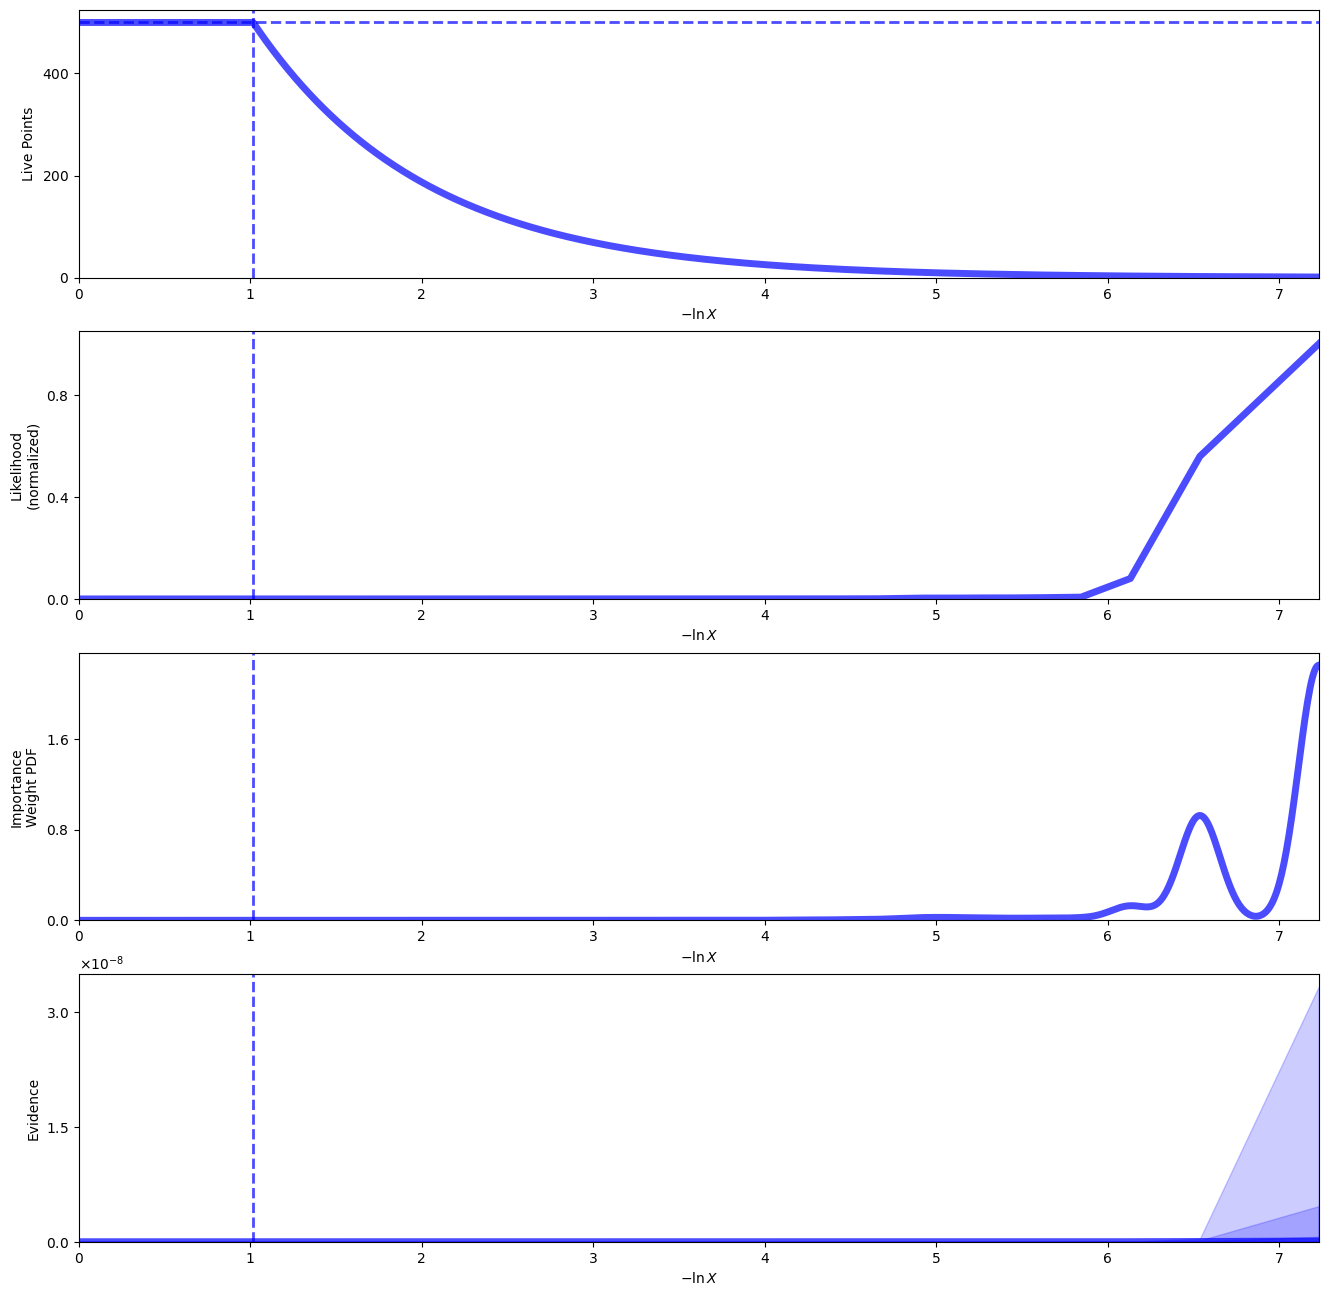

In [ ]:

rfig, raxes = dyplot.runplot(sresults)
rfig.savefig('test.png')

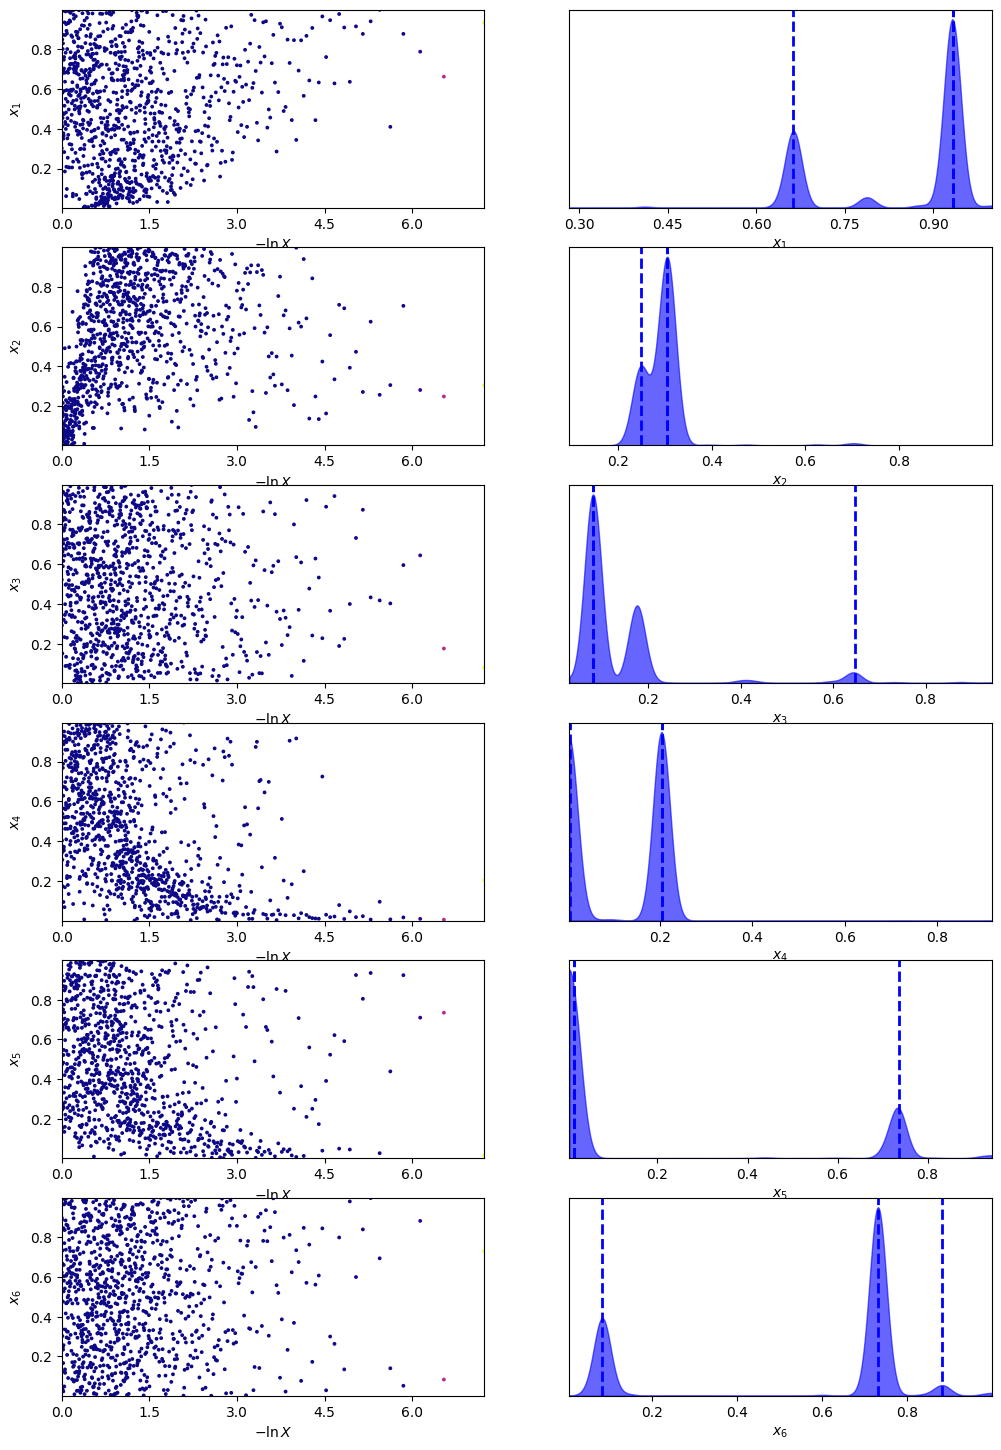

In [ ]:

# Plot traces and 1-D marginalized posteriors.
tfig, taxes = dyplot.traceplot(sresults)

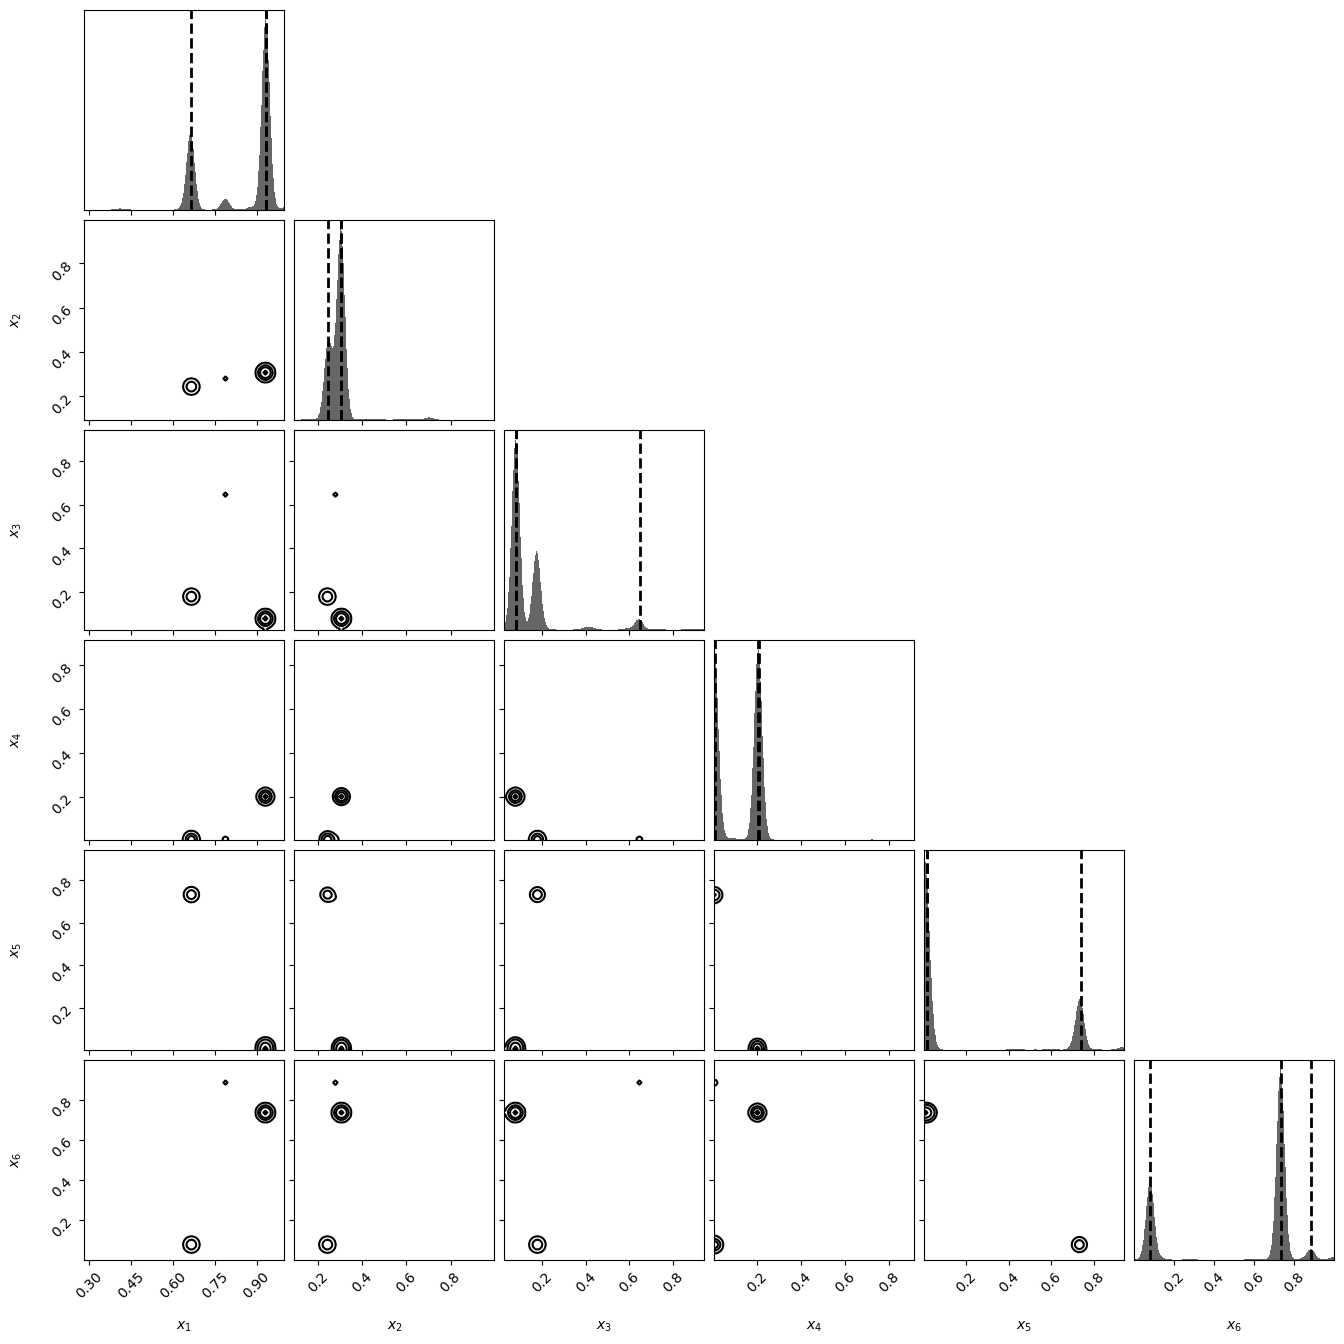

In [ ]:

# Plot the 2-D marginalized posteriors.
cfig, caxes = dyplot.cornerplot(sresults)